Description for which files are where, what is needed

### What you need

This tutorial goes from parsing data to visualizing the posterior of MDSINE2.

The tables that you will need are:
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed in objects from a previous tutorial. For this tutorial we unpacking our data into it's composite tables to walk you through constructing your own `Study` objects


In [1]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

md2.LoggingConfig(level=logging.INFO)

In [2]:
# Make example datasets from preprocessed data
def make_toy(dset):
    to_delete = []
    for taxa in dset.taxas:
        if taxa.idx >= 15:
            to_delete.append(taxa.name)
    dset.pop_taxas(to_delete)
    
    os.makedirs(os.path.join('data',dset.name+'-toy'), exist_ok=True)
    dset.write_metadata_to_csv(path=os.path.join('data',dset.name+'-toy','metadata.tsv'))
    dset.write_qpcr_to_csv(path=os.path.join('data',dset.name+'-toy','qpcr.tsv'))
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=os.path.join('data',dset.name+'-toy','perturbations.tsv'))
    dset.write_reads_to_csv(path=os.path.join('data',dset.name+'-toy','reads.tsv'))
    dset.taxas.write_taxonomy_to_csv(path=os.path.join('data',dset.name+'-toy','taxonomy.tsv'))

In [3]:
healthy = md2.Study.load('../processed_data/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('../processed_data/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('../processed_data/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [4]:
# Load metadata table
metadata = pd.read_csv('data/healthy-toy/metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [5]:
# qPCR table
qpcr = pd.read_csv('data/healthy-toy/qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [6]:
perturbations = pd.read_csv('data/healthy-toy/perturbations.tsv', sep='\t')
perturbations

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [7]:
reads = pd.read_csv('data/healthy-toy/reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,2-D22AM,2-D22PM,2-D23AM,2-D23PM,2-D24,2-D25,2-D28AM,2-D28PM,2-D29AM,2-D29PM,2-D2AM,2-D2PM,2-D30AM,2-D30PM,2-D31AM,2-D31PM,2-D32,2-D33,2-D35AM,2-D35PM,2-D36AM,2-D36PM,2-D37AM,2-D37PM,2-D38,2-D39,2-D3AM,2-D3PM,2-D42AM,2-D42PM,2-D43AM,2-D43PM,2-D44AM,2-D44PM,2-D45AM,2-D45PM,2-D46,2-D47,2-D4AM,2-D4PM,2-D5,2-D50AM,2-D50PM,2-D51AM,2-D51PM,2-D52AM,2-D52PM,2-D53,2-D54,2-D57AM,2-D57PM,2-D58AM,2-D58PM,2-D59AM,2-D59PM,2-D6,2-D60AM,2-D60PM,2-D61,2-D62,2-D63,2-D64AM,2-D64PM,2-D7,2-D8,2-D9,3-D10,3-D11,3-D14,3-D16,3-D18,3-D1AM,3-D1PM,3-D21AM,3-D21PM,3-D22AM,3-D22PM,3-D23AM,3-D23PM,3-D24,3-D25,3-D28AM,3-D29AM,3-D29PM,3-D2AM,3-D2PM,3-D30AM,3-D30PM,3-D31AM,3-D31PM,3-D32,3-D33,3-D35AM,3-D35PM,3-D36AM,3-D36PM,3-D37AM,3-D38,3-D39,3-D3AM,3-D3PM,3-D42AM,3-D42PM,3-D43AM,3-D43PM,3-D44AM,3-D44PM,3-D45AM,3-D45PM,3-D46,3-D47,3-D4AM,3-D4PM,3-D5,3-D50AM,3-D50PM,3-D51AM,3-D51PM,3-D52AM,3-D52PM,3-D53,3-D54,3-D57AM,3-D57PM,3-D58AM,3-D58PM,3-D59AM,3-D59PM,3-D6,3-D60AM,3-D60PM,3-D61,3-D62,3-D63,3-D64AM,3-D64PM,3-D7,3-D8,3-D9,4-D10,4-D11,4-D14,4-D16,4-D18,4-D1AM,4-D1PM,4-D21AM,4-D21PM,4-D22AM,4-D22PM,4-D23AM,4-D23PM,4-D24,4-D25,4-D28AM,4-D29AM,4-D29PM,4-D2AM,4-D2PM,4-D30AM,4-D30PM,4-D31AM,4-D31PM,4-D32,4-D33,4-D35AM,4-D35PM,4-D36AM,4-D36PM,4-D37AM,4-D37PM,4-D38,4-D39,4-D3AM,4-D3PM,4-D42AM,4-D42PM,4-D43AM,4-D43PM,4-D44AM,4-D44PM,4-D45AM,4-D45PM,4-D46,4-D47,4-D4AM,4-D4PM,4-D5,4-D50AM,4-D50PM,4-D51AM,4-D51PM,4-D52AM,4-D52PM,4-D53,4-D54,4-D57AM,4-D57PM,4-D58AM,4-D58PM,4-D59AM,4-D59PM,4-D6,4-D60AM,4-D60PM,4-D61,4-D62,4-D63,4-D64AM,4-D64PM,4-D7,4-D8,4-D9,5-D10,5-D11,5-D14,5-D16,5-D18,5-D1AM,5-D1PM,5-D21AM,5-D21PM,5-D22AM,5-D22PM,5-D23AM,5-D23PM,5-D24,5-D25,5-D28AM,5-D28PM,5-D29AM,5-D29PM,5-D2AM,5-D2PM,5-D30AM,5-D30PM,5-D31AM,5-D31PM,5-D32,5-D33,5-D35AM,5-D35PM,5-D36AM,5-D36PM,5-D37AM,5-D37PM,5-D38,5-D39,5-D3AM,5-D3PM,5-D42AM,5-D42PM,5-D43AM,5-D43PM,5-D44AM,5-D44PM,5-D45AM,5-D45PM,5-D46,5-D47,5-D4AM,5-D4PM,5-D5,5-D50AM,5-D50PM,5-D51AM,5-D51PM,5-D52AM,5-D52PM,5-D53,5-D54,5-D57AM,5-D57PM,5-D58AM,5-D58PM,5-D59AM,5-D59PM,5-D6,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,3866,3899,1984,807,2299,1349,1074,855,3479,3910,489,1056,5113,5624,7096,5788,10237,2784,2711,2421,1554,1216,259,154,114,100,1474,3227,1963,2950,126,202,207,222,89,50,185,180,7637,4237,5597,53,47,29,48,162,37,188,2349,5520,3265,3892,3881,1646,1805,6129,1913,6688,1730,1269,651,987,853,9591,2503,234,6265,6822,1831,2874,6154,235,202,7102,7624,6024,3889,4683,5921,3608,4278,2865,5330,7488,340,227,7926,5061,5108,4923,4988,5879,4039,4822,3009,4213,609,197,123,1398,1945,1365,1652,4512,741,455,461,99,54,386,134,4408,4276,2734,124,209,55,80,249,107,341,109,168,194,713,637,539,564,3804,806,891,833,775,545,525,845,4798,4650,5987,398,1744,11041,9437,9948,4695,195,5562,3920,1638,1210,1235,639,929,1277,4084,5681,6144,222,176,4690,3737,5519,5504,3350,6638,3696,3697,1529,2179,3757,1466,182,96,183,461,8678,7682,5384,2311,1032,1101,263,153,426,167,1900,2509,3240,157,182,71,59,267,154,133,109,116,36,122,90,20,13,6844,125,63,96,63,51,34,76,5459,3853,585,5152,4173,11816,5113,5642,5033,230,6454,5745,4194,7218,8262,1512,2093,3224,2091,1650,3840,11932,620,852,8741,5593,6152,3740,500,307,52,77,99,95,182,135,135,123,1198,3491,395,38,60,35,96,136,38,27,137,162,3943,5485,5746,49,103,39,80,222,205,115,29,73,135,140,223,83,192,6401,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,2725,1792,466,51,86,38,25,34,1317,2217,24422,17184,5490,5924,6906,7466,9783,7856,10490,9939,18164,17769,16694,8553,8842,5806,11193,15984,8567,6995,5108,6693,5785,6963,5880,6755,8239,7199,21915,13035,15798,625,751,2368,2556,632,206,278,177,644,1857,5473,5433,2847,2693,14811,2652,8942,3765,4053,2497,4608,4569,12926,8541,12646,11800,14693,20597,10165,19883,8032,19079,24905,21860,2601,1059,309,152,130,124,46,1130,3653,23489,17698,9339,7694,7429,8762,9965,15319,9470,13328,1292

### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [8]:
taxonomy = pd.read_csv('data/healthy-toy/taxonomy.tsv', sep='\t')
taxonomy

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/dorei
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [9]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy='data/healthy-toy/taxonomy.tsv', 
                         reads='data/healthy-toy/reads.tsv', 
                         qpcr='data/healthy-toy/qpcr.tsv', 
                         perturbations='data/healthy-toy/perturbations.tsv', 
                         metadata='data/healthy-toy/metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy='data/uc-toy/taxonomy.tsv', 
                         reads='data/uc-toy/reads.tsv', 
                         qpcr='data/uc-toy/qpcr.tsv', 
                         perturbations='data/uc-toy/perturbations.tsv', 
                         metadata='data/uc-toy/metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy='data/replicates-toy/taxonomy.tsv', 
                         reads='data/replicates-toy/reads.tsv', 
                         qpcr='data/replicates-toy/qpcr.tsv', 
                         metadata='data/replicates-toy/metadata.tsv')


INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting


You would just read these in with this parser. These are identical to our precomputed dataset 

# Learning the Negative Binomial dispersion parameters

This corresponds to the script ``

words here

In [10]:
# Description

In [11]:
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    ckpt=100, basepath='output/negbin/run2')

description

In [12]:
mcmc_negbin = md2.negbin.build_graph(params=params, graph_name=rep_toy.name, 
                              subjset=rep_toy)

INFO:inference.550: Setting Single Write, Multiple Read Mode
INFO:inference.555: Setting the trace of learned parameters
INFO:inference.556: #######################################
INFO:inference.558: Setting the trace of Negative binomial dispersion a0
INFO:inference.558: Setting the trace of Negative binomial dispersion a1
INFO:inference.558: Setting the trace of Filtering
INFO:inference.560: Setting the trace for diagnostic variables
INFO:inference.561: ##########################################


description

In [13]:
mcmc_negbin = md2.negbin.run_graph(mcmc_negbin, crash_if_error=True)

INFO:inference.429: 

Inference iteration 0/200, time: 0.0
INFO:inference.438: Negative binomial dispersion a0: 1e-10
INFO:inference.438: Negative binomial dispersion a1: 0.1
INFO:inference.438: Filtering: NA
INFO:inference.429: 

Inference iteration 1/200, time: 0.28203344345092773
INFO:inference.438: Negative binomial dispersion a0: Value: 1e-10, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.09932993484270942, Acceptance rate: 1.0
INFO:inference.438: Filtering: no-mp : Time: 0.0090, Acc: [0.333, 0.200, 0.333], data/sec: 5000.10
INFO:inference.429: 

Inference iteration 2/200, time: 0.005995512008666992
INFO:inference.438: Negative binomial dispersion a0: Value: 9.612139383543583e-11, Acceptance rate: 0.5
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07611843510778384, Acceptance rate: 1.0
INFO:inference.438: Filtering: no-mp : Time: 0.0020, Acc: [0.333, 0.267, 0.533], data/sec: 22202.53
INFO:inference.429: 

Inference iteration 3/2

INFO:inference.438: Negative binomial dispersion a0: Value: 5.433152020006895e-11, Acceptance rate: 0.42857142857142855
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.6190476190476191
INFO:inference.438: Filtering: no-mp : Time: 0.0020, Acc: [0.267, 0.267, 0.267], data/sec: 22236.53
INFO:inference.429: 

Inference iteration 22/200, time: 0.00599980354309082
INFO:inference.438: Negative binomial dispersion a0: Value: 5.096746550369834e-11, Acceptance rate: 0.45454545454545453
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.5909090909090909
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.333, 0.467], data/sec: 14844.17
INFO:inference.429: 

Inference iteration 23/200, time: 0.005998134613037109
INFO:inference.438: Negative binomial dispersion a0: Value: 3.436668653129214e-11, Acceptance rate: 0.4782608695652174
INFO:inference.438: Negative binomial dispersion a1: V

INFO:inference.438: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6341463414634146
INFO:inference.438: Filtering: no-mp : Time: 0.0020, Acc: [0.333, 0.533, 0.267], data/sec: 22523.11
INFO:inference.429: 

Inference iteration 42/200, time: 0.006020307540893555
INFO:inference.438: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.40476190476190477
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6190476190476191
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.200, 0.333, 0.133], data/sec: 14864.05
INFO:inference.429: 

Inference iteration 43/200, time: 0.0059964656829833984
INFO:inference.438: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.3953488372093023
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05003316278345163, Acceptance rate: 0.627906976744186
INFO:inference.438: Filtering: no-mp : Time: 0.0030, A

INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.24
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07591896190663665, Acceptance rate: 0.56
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 14853.52
INFO:inference.429: 

Inference iteration 63/200, time: 0.009001016616821289
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06881053138741283, Acceptance rate: 0.56
INFO:inference.438: Filtering: no-mp : Time: 0.0040, Acc: [0.467, 0.400, 0.467], data/sec: 11255.51
INFO:inference.429: 

Inference iteration 64/200, time: 0.005987405776977539
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06514442553913363, Acceptance rate: 0.58
INFO:inference.438:

INFO:inference.438: Negative binomial dispersion a1: Value: 0.059167916859363984, Acceptance rate: 0.52
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.400, 0.333], data/sec: 15003.47
INFO:inference.429: 

Inference iteration 84/200, time: 0.00600123405456543
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.52
INFO:inference.438: Filtering: no-mp : Time: 0.0020, Acc: [0.600, 0.267, 0.200], data/sec: 22512.37
INFO:inference.429: 

Inference iteration 85/200, time: 0.0060346126556396484
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.5
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.267, 0.600], data/sec: 14826.68
INFO:inference.429: 

Inf

INFO:inference.438: Filtering: no-mp : Time: 0.0040, Acc: [0.533, 0.400, 0.333], data/sec: 11206.73
INFO:inference.429: 

Inference iteration 105/200, time: 0.006017923355102539
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05764379659694878, Acceptance rate: 0.46
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.267], data/sec: 14887.50
INFO:inference.429: 

Inference iteration 106/200, time: 0.005999565124511719
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05503986513928517, Acceptance rate: 0.48
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.467, 0.333], data/sec: 14854.69
INFO:inference.429: 

Inference iteration 107/200, time: 0.005996227264404297
INFO:inference.438: Negative binomial dispersion a

INFO:inference.429: 

Inference iteration 126/200, time: 0.005999088287353516
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05229144933116436, Acceptance rate: 0.48
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.133], data/sec: 15004.66
INFO:inference.429: 

Inference iteration 127/200, time: 0.006000995635986328
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06848080232784978, Acceptance rate: 0.48
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.600, 0.467], data/sec: 15001.09
INFO:inference.429: 

Inference iteration 128/200, time: 0.005998849868774414
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispers

INFO:inference.438: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.6
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 15001.09
INFO:inference.429: 

Inference iteration 148/200, time: 0.0049991607666015625
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.58
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.400], data/sec: 15002.28
INFO:inference.429: 

Inference iteration 149/200, time: 0.005014181137084961
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05291161640746216, Acceptance rate: 0.58
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.267, 0.667], data/sec: 14831.34
INFO:inference.429: 

Inf

INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.600, 0.333, 0.467], data/sec: 14992.75
INFO:inference.429: 

Inference iteration 169/200, time: 0.005971193313598633
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07936467417134285, Acceptance rate: 0.58
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.333, 0.467], data/sec: 15004.66
INFO:inference.429: 

Inference iteration 170/200, time: 0.006024599075317383
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07228201190866185, Acceptance rate: 0.6
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.467, 0.467], data/sec: 14868.73
INFO:inference.429: 

Inference iteration 171/200, time: 0.007007122039794922
INFO:inference.438: Negative binomial dispersion a0

INFO:inference.429: 

Inference iteration 190/200, time: 0.00497126579284668
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.467], data/sec: 15115.21
INFO:inference.429: 

Inference iteration 191/200, time: 0.005007505416870117
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.438: Filtering: no-mp : Time: 0.0020, Acc: [0.467, 0.400, 0.467], data/sec: 22633.85
INFO:inference.429: 

Inference iteration 192/200, time: 0.006025075912475586
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersi

description, we are repeating this on the smaller dataset so you know how to run it and know what it looks like. This is not representative of the real results because we only have the ten most abundant taxa here.

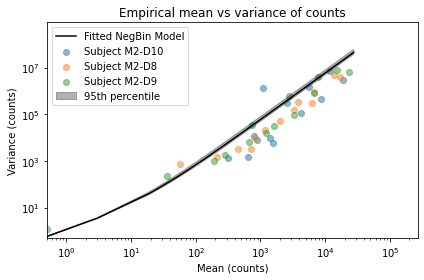

In [14]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()

# Run the model

In [15]:
# Get a0 and a1 from negbin (get the mean of the posterior)
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = 'output/mdsine2/uc0'
os.makedirs(basepath, exist_ok=True)


# Initialize parameters of the model
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.1642672989308661e-13
negbin a1 0.05972242507901712


In [16]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inte

INFO:run.369: 	perturbation High Fat Diet
INFO:run.370: 		value: {2110283172216: 0, 2110283173448: 0, 2110280718208: 0, 2110289035672: 0, 2110289038696: 0, 2110289036232: 0, 2110289037576: 0, 2110289035784: 0, 2110289037184: 0, 2110289039256: 0, 2110289035560: 0, 2110249117288: 0, 2110249119192: 0, 2110238520488: 0, 2110238520376: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2110283172216: 0, 2110283173448: 0, 2110280718208: 0, 2110289035672: 0, 2110289038696: 0, 2110289036232: 0, 2110289037576: 0, 2110289035784: 0, 2110289037184: 0, 2110289039256: 0, 2110289035560: 0, 2110249117288: 0, 2110249119192: 0, 2110238520488: 0, 2110238520376: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2110283172216: 0, 2110283173448: 0, 2110280718208: 0, 2110289035672: 0, 2110289038696: 0, 2110289036232: 0, 2110289037576: 0, 2110289035784: 0, 2110289037184: 0, 2110289039256: 0, 2110289035560: 0, 211024911728

In [17]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

INFO:inference.429: 

Inference iteration 0/100, time: 0.0
INFO:inference.438: Cluster interaction indicator parameter: None
INFO:inference.438: Cluster interaction probability: 0.09234190994988938
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: Nones
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (0/15): [False False False False False False False False False False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1527842458791451
	perturbation Vancomycin: 0.1527842458791451
	perturbation Gentamicin: 0.1527842458791451
INFO:inference.438: Logistic growth parameters (growth, se

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 9.483892334955561
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -5.633760869066583
	perturbation Vancomycin: -32.394691549238026
	perturbation Gentamicin: 19.22092898194378
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.155360661555971, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7886622384767377, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 4047.7156572959684
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 204.06655221025355
	perturbation Vancomycin: 1115.7342315369867
	perturbation Gen

INFO:inference.438: Cluster interaction probability: 0.06389609988570996
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.01399993896484375s
perturbation High Fat Diet (1/15): [False False False False False  True False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False  True False False False  True False False]
perturbation Gentamicin (2/15): [False False False False False False False  True False False False False  True False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.025066240399094393
	perturbation Vancomycin: 0.09438846925304158
	perturbation Gentamicin: 0.311140162497224
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.05133125 0.35152011 0.35811711 0.31745151 0.4834657

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 2110283172216
	members: ['OTU_1']
	size: 1
Cluster 2110283173448
	members: ['OTU_2']
	size: 1
Cluster 2110280718208
	members: ['OTU_3']
	size: 1
Cluster 2110289035672
	members: ['OTU_4']
	size: 1
Cluster 2110289038696
	members: ['OTU_5']
	size: 1
Cluster 2110289036232
	members: ['OTU_6']
	size: 1
Cluster 2110289037576
	members: ['OTU_7']
	size: 1
Cluster 2110289035784
	members: ['OTU_8']
	size: 1
Cluster 2110289037184
	members: ['OTU_9']
	size: 1
Cluster 2110289039256
	members: ['OTU_10']
	size: 1
Cluster 2110289035560
	members: ['OTU_12']
	size: 1
Cluster 2110249117288
	members: ['OTU_13']
	size: 1
Cluster 2110249119192
	members: ['OTU_16']
	size: 1
Cluster 2110238520488
	members: ['OTU_17']
	size: 1
Cluster 2110238520376
	members: ['OTU_18']
	size: 1
no mp - Total time: -1
INFO:inference.438: Clustering concentration parameter: 2548.488953421099
INF

INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.01100015640258789s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False  True False False False False False False False False  True False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.005254677692387669
	perturbation Vancomycin: 0.04639894281243465
	perturbation Gentamicin: 0.040104728261029246
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.33177439 0.23173319 0.58432372 0.06610666 0.73834138 0.65857475 0.17773049 0.33446167 0.08571536 0.04545877 0.34153927 0.

INFO:inference.438: Clustering concentration parameter: 1911.8214434472347
INFO:inference.429: 

Inference iteration 8/100, time: 0.37499451637268066
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -5.875981414240699
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -44.2834954234983
	perturbation Vancomycin: 39.578245723002055
	perturbation Gentamicin: 108.43612806147931
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.1725488535722538, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.023609220288695165, Acceptance rate: 0.8888888888888888
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 99.50522803463701
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3084.787657626476
	perturbation Vancomycin: 3652.812212820237
	p

INFO:inference.438: Cluster interaction probability: 0.0068311938286222595
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.011996746063232422s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False  True False  True False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02424975560847808
	perturbation Vancomycin: 0.2318151062030672
	perturbation Gentamicin: 0.0196823200422439
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.77828705 0.38903905 0.76961277 0.10587474 0.59827

INFO:inference.438: Clustering concentration parameter: 46196.9865769058
INFO:posterior.1569: 0/15: 7
INFO:posterior.1569: 1/15: 3
INFO:posterior.1569: 2/15: 12
INFO:posterior.1569: 3/15: 0
INFO:posterior.1569: 4/15: 11
INFO:posterior.1569: 5/15: 5
INFO:posterior.1569: 6/15: 8
INFO:posterior.1569: 7/15: 2
INFO:posterior.1569: 8/15: 9
INFO:posterior.1569: 9/15: 4
INFO:posterior.1569: 10/15: 1
INFO:posterior.1569: 11/15: 13
INFO:posterior.1569: 12/15: 6
INFO:posterior.1569: 13/15: 10
INFO:posterior.1569: 14/15: 14
INFO:inference.429: 

Inference iteration 13/100, time: 0.8659682273864746
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -13.067550170745013
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -49.33790452466888
	perturbation Vancomycin: -19.32263898976616
	perturbation Gentamicin: 36.94523669541384
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.19204162144120313, Acceptance rate: 0.9285714285714286
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4716932146951434, Acceptance rate: 0.9285714285714286
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 207.33219200003012
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1562.0175682655426
	perturbation Vancomycin: 127

INFO:inference.438: Cluster interaction probability: 0.010175892449755676
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.013007640838623047s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (3/14): [False False  True False False False False False  True False  True False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06794194655834933
	perturbation Vancomycin: 0.2848361803874093
	perturbation Gentamicin: 0.01815317067353581
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.57186    0.25918816 0.41144759 0.04077873 0.45196503 0.29776085 0.4

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 2110269842096
	members: ['OTU_8']
	size: 1
Cluster 2110248209768
	members: ['OTU_13']
	size: 1
Cluster 2110287034072
	members: ['OTU_17']
	size: 1
Cluster 2110237300496
	members: ['OTU_1']
	size: 1
Cluster 2110249117288
	members: ['OTU_3']
	size: 1
Cluster 2110286189680
	members: ['OTU_4']
	size: 1
Cluster 2110283173448
	members: ['OTU_9']
	size: 1
Cluster 2110289107264
	members: ['OTU_6']
	size: 1
Cluster 2110289132848
	members: ['OTU_10']
	size: 1
Cluster 2110282885552
	members: ['OTU_2']
	size: 1
Cluster 2110280718208
	members: ['OTU_5']
	size: 1
Cluster 2110268048272
	members: ['OTU_16']
	size: 1
Cluster 2110247152608
	members: ['OTU_18']
	size: 1
Cluster 2110288965304
	members: ['OTU_7']
	size: 1
Cluster 2110248411264
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.5119688510894775
INFO:inference.438: Clustering concentration parameter: 8782.

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.022773527393008204
	perturbation Vancomycin: 0.18961843763878664
	perturbation Gentamicin: 0.02287902360921469
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.50211482 0.55354115 0.44499459 0.12225876 0.24717666 0.4392869  0.25878646 0.56812106 0.03167013 0.14417458 0.4485719  0.03269078 0.84751399 0.6284677  0.53410387]
Self Interactions:
[3.51833846e-01 2.80268950e-01 2.33673967e-01 5.75489842e+00 1.31250938e+00 1.60417699e-01 1.82008171e+00 1.26950984e+00 1.70063206e+02 7.40706417e+01 2.25979149e+00 5.12543728e+01 4.29204050e+00 5.11780422e+00 5.91581913e+00]
Interactions:
[-1.00869866]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.82353956 -3.55865574]
	 perturbation Gentamici

INFO:inference.438: Clustering concentration parameter: 4686.538240363071
INFO:posterior.1569: 0/15: 5
INFO:posterior.1569: 1/15: 6
INFO:posterior.1569: 2/15: 9
INFO:posterior.1569: 3/15: 0
INFO:posterior.1569: 4/15: 7
INFO:posterior.1569: 5/15: 2
INFO:posterior.1569: 6/15: 1
INFO:posterior.1569: 7/15: 10
INFO:posterior.1569: 8/15: 13
INFO:posterior.1569: 9/15: 11
INFO:posterior.1569: 10/15: 8
INFO:posterior.1569: 11/15: 14
INFO:posterior.1569: 12/15: 12
INFO:posterior.1569: 13/15: 4
INFO:posterior.1569: 14/15: 3
INFO:inference.429: 

Inference iteration 21/100, time: 0.894965410232544
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 5.105691517572982
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -80.4250569642775
	perturbation Vancomycin: -3.354187626392411
	perturbation Gentamicin: -103.03261094141894
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.09111761552527323, Acceptance rate: 0.9545454545454546
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.066352395634604, Acceptance rate: 0.9545454545454546
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 57.84198115299653
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3593.699155841727
	perturbation Vancomycin: 896.906

INFO:inference.438: Cluster interaction probability: 0.014292118372849674
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010998964309692383s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False  True False False False  True False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0062401252205628085
	perturbation Vancomycin: 0.07941152466551692
	perturbation Gentamicin: 0.001581075713701379
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.58717082 0.50782226 0.34436335 0.22619066 0.6

INFO:inference.438: Process Variance parameter: 3.798090094147076, empirical_variance: 3.79895
INFO:inference.438: Filtering: no-mp - Time: 0.2670, Acc: [0.630, 0.621, 0.624, 0.626, 0.625], data/sec: 21067.04
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 2110287032896
	members: ['OTU_16']
	size: 1
Cluster 2110282118592
	members: ['OTU_3']
	size: 1
Cluster 2110268086312
	members: ['OTU_5']
	size: 1
Cluster 2110239579272
	members: ['OTU_2']
	size: 1
Cluster 2110287893280
	members: ['OTU_8']
	size: 1
Cluster 2110248411264
	members: ['OTU_13']
	size: 1
Cluster 2110248208648
	members: ['OTU_12']
	size: 1
Cluster 2110239579104
	members: ['OTU_10']
	size: 1
Cluster 2110282120608
	members: ['OTU_18']
	size: 1
Cluster 2110269842096
	members: ['OTU_17']
	size: 1
Cluster 2110248209768
	members: ['OTU_7']
	size: 1
Cluster 2110287034072
	members: ['OTU_6']
	size: 1
Cluster 2110282721656
	members: ['OTU_1']
	s

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.020216736735856045
	perturbation Vancomycin: 0.07020376342721854
	perturbation Gentamicin: 0.010119656479977673
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56184603 0.26993375 0.68895657 0.03305147 0.4539164  0.65133847 0.26860908 0.36117722 0.23904449 0.11404575 0.57277532 0.23584795 0.90563875 0.50554622 0.1236777 ]
Self Interactions:
[4.37087097e-01 1.76695074e-01 3.10821422e-01 4.75922162e+00 9.69529802e-01 2.97686893e-01 1.87152068e+00 1.17780091e+00 1.79438049e+02 1.53490928e+02 3.07480213e+00 6.43524957e+01 5.19337801e+00 3.43137414e+00 2.86912411e+00]
Interactions:
[ -1.4934615  -32.41815385]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.19257031 -3.45562613]
	 perturb

INFO:inference.438: Clustering concentration parameter: 2250.799331988446
INFO:posterior.1569: 0/15: 3
INFO:posterior.1569: 1/15: 11
INFO:posterior.1569: 2/15: 8
INFO:posterior.1569: 3/15: 9
INFO:posterior.1569: 4/15: 12
INFO:posterior.1569: 5/15: 2
INFO:posterior.1569: 6/15: 6
INFO:posterior.1569: 7/15: 4
INFO:posterior.1569: 8/15: 7
INFO:posterior.1569: 9/15: 14
INFO:posterior.1569: 10/15: 0
INFO:posterior.1569: 11/15: 13
INFO:posterior.1569: 12/15: 5
INFO:posterior.1569: 13/15: 10
INFO:posterior.1569: 14/15: 1
INFO:inference.429: 

Inference iteration 29/100, time: 0.870582103729248
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.3516045458300046
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 165.00498465348358
	perturbation Vancomycin: -0.781483033792032
	perturbation Gentamicin: 192.28738173782048
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.45450865654076866, Acceptance rate: 0.9666666666666667
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9702634761617144, Acceptance rate: 0.9666666666666667
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 155.57296789225526
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2178.600512181818
	perturbation Vancomycin: 585.

INFO:inference.438: Cluster interaction probability: 0.03403704785607163
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.011999130249023438s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (2/14): [False False False False  True False False False False False False  True False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.042222948149309936
	perturbation Vancomycin: 0.16399039953985406
	perturbation Gentamicin: 0.021788113219646004
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.84047773 0.08387828 0.77886702 0.16137554 0.63840965 0.48595268 0

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 2110247310616
	members: ['OTU_6', 'OTU_17', 'OTU_18']
	size: 3
Cluster 2110282720592
	members: ['OTU_10']
	size: 1
Cluster 2110268107912
	members: ['OTU_16']
	size: 1
Cluster 2110268086312
	members: ['OTU_13']
	size: 1
Cluster 2110288986184
	members: ['OTU_5']
	size: 1
Cluster 2110287893280
	members: ['OTU_8']
	size: 1
Cluster 2110280718208
	members: ['OTU_2']
	size: 1
Cluster 2110289035560
	members: ['OTU_7']
	size: 1
Cluster 2110248208648
	members: ['OTU_4']
	size: 1
Cluster 2110283173448
	members: ['OTU_1']
	size: 1
Cluster 2110248209768
	members: ['OTU_3']
	size: 1
Cluster 2110286189680
	members: ['OTU_12']
	size: 1
Cluster 2110268048272
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.47800278663635254
INFO:inference.438: Clustering concentration parameter: 245.56206987610045
INFO:inference.429: 

Inference iteration 34/100, time: 0.36899828910

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -32.713772926104184
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -87.45151800388136
	perturbation Vancomycin: -12.79129800003728
	perturbation Gentamicin: -121.55582111232921
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.012646592288825, Acceptance rate: 0.9714285714285714
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.5095588228426244, Acceptance rate: 0.9714285714285714
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 646.380768708048
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 7497.29849914634
	perturbation Vancomycin: 3012.69

INFO:inference.438: Cluster interaction probability: 0.016532213700613696
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.01199960708618164s
perturbation High Fat Diet (1/13): [False False False False False False False False False False False  True False]
perturbation Vancomycin (2/13): [ True False False False False False  True False False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.04404529311726189
	perturbation Vancomycin: 0.28409085813151297
	perturbation Gentamicin: 0.03820911258554468
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.44317974 0.45404138 0.48893632 0.03831899 0.80892946 0.68972006 0.7590049  0.4885083 

INFO:inference.438: Clustering concentration parameter: 72.00151348700811
INFO:inference.429: 

Inference iteration 39/100, time: 0.3730173110961914
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False  True False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 1402.4034255013928
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1006.3359938954585
	perturbation Vancomycin: 2327.9671054025134
	perturbation Gentamicin: 6176.894265914315
INFO:inference.438: Process Variance parameter: 3.1697789078731815, empirical_variance: 3.15208
INFO:inference.438: Filtering: no-mp - Time: 0.2690, Acc: [0.625, 0.651, 0.606, 0.643, 0.635], data/sec: 20908.33
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 2110247310616
	members: ['OTU_18']
	size: 1
Cluster 2110289035560
	members: ['OTU_6', 'OTU_7', 'OTU_17']
	size: 3
Cluster 2110281903408
	members: ['OTU_10']
	size: 1
Cluster 2110282721880
	members: ['OTU_13']
	size: 1
Cluster 2110289038696
	members: ['OTU_9']
	size: 1
Cluster 

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.05505990074949393
	perturbation Vancomycin: 0.08684758246437149
	perturbation Gentamicin: 0.0005551075977827372
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.4655889  0.53212905 0.5398998  0.12482878 0.65387559 0.65948234 0.42734901 0.5573341  0.06178733 0.0767027  0.25796194 0.24098085 0.74873666 0.76651218 0.19787338]
Self Interactions:
[  0.33642832   0.25313544   0.26135986   1.27656405   1.39173796   0.40004768   0.96417502   1.47581505 196.96742764 178.67361723   1.97169359 104.76792178   4.50523781   4.06977693   4.11644047]
Interactions:
[-90.79655625  -0.67438345  -0.68607064 -50.15656831   6.04026568]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.2336898]
	 perturbatio

INFO:inference.438: Cluster interaction probability: 0.0853216917870897
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.013000249862670898s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [False False False False  True False False False False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.067443724336777
	perturbation Vancomycin: 0.06430530796074169
	perturbation Gentamicin: 0.006275628983118937
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.58537439 0.31995623 0.36599508 0.17947992 0.44007926 0.7200949  0.56553686 0.40228218 0

INFO:inference.438: Clustering concentration parameter: 4.122174987358082
INFO:inference.429: 

Inference iteration 46/100, time: 0.335970401763916
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False  True False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False]
total time: 0.029032468795776367, n_interactions: 4/90, 0.04
INFO:inference.438: Cluster interaction probability: 0.08131669019334857
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009003400802612305s
perturb

INFO:inference.438: Clustering concentration parameter: 10.882799344695167
INFO:inference.429: 

Inference iteration 48/100, time: 0.33330702781677246
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False  True False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False]
total time: 0.03299689292907715, n_interactions: 4/90, 0.04
INFO:inference.438: Cluster interaction probability: 0.03939279726047478
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000539779663086s
pertu

INFO:inference.438: Filtering: no-mp - Time: 0.2530, Acc: [0.615, 0.634, 0.617, 0.620, 0.599], data/sec: 22230.31
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 2110282886000
	members: ['OTU_2', 'OTU_13']
	size: 2
Cluster 2110248411264
	members: ['OTU_16', 'OTU_17']
	size: 2
Cluster 2110289107264
	members: ['OTU_6', 'OTU_7']
	size: 2
Cluster 2110289050480
	members: ['OTU_1']
	size: 1
Cluster 2110280718208
	members: ['OTU_12', 'OTU_18']
	size: 2
Cluster 2110268086312
	members: ['OTU_8']
	size: 1
Cluster 2110288921208
	members: ['OTU_9']
	size: 1
Cluster 2110248208648
	members: ['OTU_4']
	size: 1
Cluster 2110288965304
	members: ['OTU_5']
	size: 1
Cluster 2110249117288
	members: ['OTU_10']
	size: 1
Cluster 2110268048272
	members: ['OTU_3']
	size: 1
no mp - Total time: 0.3860006332397461
INFO:inference.438: Clustering concentration parameter: 17.59937667589965
INFO:inference.429: 

Inference iteration

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.0143869065445075, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.8793513258558252, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 4902.140275843839
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2406.905849469784
	perturbation Vancomycin: 1794.333271569936
	perturbation Gentamicin: 677.6188415556101
INFO:inference.438: Process Variance parameter: 2.8535489513628503, empirical_variance: 2.87470
INFO:inference.438: Filtering: no-mp - Time: 0.2576, Acc: [0.630, 0.635, 0.631, 0.604, 0.594], data/sec: 21838.05
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 1

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.59954736 0.45684774 0.48394383 0.12920153 0.67594129 0.6412178  0.58027679 0.43003575 0.45219554 0.15699966 0.82944165 0.2183074  0.00157433 0.72422938 0.4543799 ]
Self Interactions:
[3.97604551e-01 2.67436649e-01 2.23817172e-01 5.12081393e+00 1.42483629e+00 3.12357883e-01 3.50974748e-01 1.19969893e+00 2.71512448e+02 2.68674480e+02 2.46707648e+00 1.31273719e+02 1.76889515e+00 4.17222308e+00 4.83087594e+00]
Interactions:
[  -0.11098637   -0.30768372  -40.53708173    4.1382516   -28.62630299 -109.47181015]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.43796173]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -42.58192999406973
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude 

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.12055131181254902
	perturbation Vancomycin: 0.017669801316500224
	perturbation Gentamicin: 0.057922324087727566
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.67157654 0.46317915 0.52981547 0.18837569 0.68529654 0.68299873 0.57971681 0.37915463 0.21048347 0.23239817 0.48781317 0.30756687 0.79320228 0.75730127 0.50180221]
Self Interactions:
[4.05775932e-01 3.01856373e-01 2.51878832e-01 3.94328949e+00 1.17097279e+00 3.92478315e-01 3.48976417e-02 1.06371700e+00 3.08686207e+02 2.47248701e+02 1.79531312e+00 1.16057014e+02 4.96014073e+00 3.57480175e+00 3.45604086e+00]
Interactions:
[-40.02041618  -0.22462546  -2.49667241 -71.34518561  11.13241613 -39.27106684 -49.19157651   1.13481455 -33.8193858 ]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 pe

INFO:inference.438: Cluster interaction probability: 0.09694508121004759
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010033130645751953s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomycin (1/9): [False  True False False False False False False False]
perturbation Gentamicin (0/9): [False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0003676675315334302
	perturbation Vancomycin: 0.24602641214012905
	perturbation Gentamicin: 0.04357676418673994
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.41728554 0.58807091 0.28465496 0.14214515 0.48524786 0.78029035 0.65463293 0.2711716  0.26217693 0.05489556 0.31752274 0.20896424 0.63389987 0.76574804 0.2425

INFO:inference.438: Cluster interaction probability: 0.025008826676992366
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007999181747436523s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomycin (1/9): [False  True False False False False False False False]
perturbation Gentamicin (0/9): [False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02832311501386283
	perturbation Vancomycin: 0.09010817238788968
	perturbation Gentamicin: 0.007977406210588732
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.51321229 0.58401122 0.57299363 0.18467742 0.65408512 0.55280243 0.56731679 0.44707094 0.33373942 0.09597634 0.43334804 0.13394865 0.99438479 0.81280099 0.4691

INFO:inference.438: Cluster interaction probability: 0.05139585026893934
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008001565933227539s
perturbation High Fat Diet (0/10): [False False False False False False False False False False]
perturbation Vancomycin (2/10): [False  True False False False False  True False False False]
perturbation Gentamicin (0/10): [False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 9.254174426096622e-05
	perturbation Vancomycin: 0.05474627794740605
	perturbation Gentamicin: 0.0008224502882445372
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.49241046 0.46563825 0.62407155 0.46301212 0.45738531 0.48489622 0.53901361 0.36594861 0.19263879 0.03736487 0.40608787 0.15917239 0.891

INFO:inference.438: Cluster interaction probability: 0.03537760989622003
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00999903678894043s
perturbation High Fat Diet (0/10): [False False False False False False False False False False]
perturbation Vancomycin (1/10): [False  True False False False False False False False False]
perturbation Gentamicin (0/10): [False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0420274942925463
	perturbation Vancomycin: 0.03608163829728973
	perturbation Gentamicin: 0.014799983498828264
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.58588231 0.56540694 0.52171772 0.14040945 0.48906184 0.63058379 0.45212746 0.3450245  0.25979146 0.06918282 0.4986555  0.21308317 0.75938334

INFO:inference.429: 

Inference iteration 65/100, time: 0.668032169342041
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False  True False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.02899932861328125, n_interactions: 2/90, 0.02
INFO:inference.438: Cluster interaction probability: 0.017603198904377632
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009023904800415039s
perturbation High Fat Diet (0/9): [False False False False False False False Fals

INFO:inference.438: Clustering concentration parameter: 14.618503857771573
INFO:inference.429: 

Inference iteration 67/100, time: 0.33203125
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False  True False  True False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False]
total time: 0.02600240707397461, n_interactions: 4/72, 0.06
INFO:inference.438: Cluster interaction probability: 0.05831353225184859
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008997917175292969s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomycin (1/9): [

INFO:posterior.1569: 0/15: 4
INFO:posterior.1569: 1/15: 5
INFO:posterior.1569: 2/15: 14
INFO:posterior.1569: 3/15: 10
INFO:posterior.1569: 4/15: 7
INFO:posterior.1569: 5/15: 13
INFO:posterior.1569: 6/15: 0
INFO:posterior.1569: 7/15: 6
INFO:posterior.1569: 8/15: 3
INFO:posterior.1569: 9/15: 9
INFO:posterior.1569: 10/15: 12
INFO:posterior.1569: 11/15: 2
INFO:posterior.1569: 12/15: 1
INFO:posterior.1569: 13/15: 11
INFO:posterior.1569: 14/15: 8
INFO:inference.429: 

Inference iteration 69/100, time: 0.6470215320587158
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False  True False  True  True False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  Tru

INFO:inference.438: Clustering concentration parameter: 7.51005981248434
INFO:inference.429: 

Inference iteration 71/100, time: 0.31795167922973633
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False  True False  True False False  True False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.023031949996948242, n_interactions: 4/56, 0.07
INFO:inference.438: Cluster interaction probability: 0.07140212713410776
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008000373840332031s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [False  True False False False False False False]
perturbation Gentamicin (0/8): [False False F

INFO:posterior.1569: 7/15: 12
INFO:posterior.1569: 8/15: 1
INFO:posterior.1569: 9/15: 8
INFO:posterior.1569: 10/15: 13
INFO:posterior.1569: 11/15: 0
INFO:posterior.1569: 12/15: 7
INFO:posterior.1569: 13/15: 5
INFO:posterior.1569: 14/15: 4
INFO:inference.429: 

Inference iteration 73/100, time: 0.5980033874511719
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False  True False  True False False  True False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.023001670837402344, n_interactions: 4/56, 0.07
INFO:inference.438: Cluster interaction probability: 0.13804913635439764
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007032155990600586s
perturbation High Fat Diet (0/7): [False Fals

INFO:inference.438: Cluster interaction probability: 0.09212404827456253
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008989095687866211s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (2/7): [False  True False False False  True False]
perturbation Gentamicin (1/7): [False False False False  True False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.01881026801147707
	perturbation Vancomycin: 0.045899625597064224
	perturbation Gentamicin: 0.12057286799146169
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.86077051 0.63036358 0.4150333  0.46761675 0.49797507 0.69084578 0.56046711 0.36507039 0.22946334 0.02413278 0.53110386 0.17333352 0.7289173  0.08364247 0.52902342]
Self Interactions:
[5.63317427e

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08454694949202321
	perturbation Vancomycin: 0.1382857854708407
	perturbation Gentamicin: 0.048249554175125706
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.88357268 0.44471385 0.40325638 0.36380245 0.69246476 0.69206652 0.57685791 0.57533603 0.08561312 0.11455348 0.63624171 0.33635236 0.95643648 1.08917856 0.94909064]
Self Interactions:
[4.52831069e-01 2.72679547e-01 2.45501326e-01 6.83425539e+00 1.28004370e+00 1.55179999e-01 4.87786776e-01 1.38391261e+00 2.36362380e+02 1.49251013e+02 2.57267496e+00 1.64612687e+02 3.08823585e+00 6.47484746e+00 4.11260616e+00]
Interactions:
[ -0.17882723 -17.05564909  -0.29423996  -6.55322474]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [ -1.455119

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -26.081196947974465
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 50.842536747401724
	perturbation Vancomycin: -18.767034434064865
	perturbation Gentamicin: 2.580329325227718
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 5.321983976065214, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.36066484127855913, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 1455.402921493475
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2683.343142712274
	perturbation Vancomycin: 1123.0452334193342
	perturbation 

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 5.632877362826688, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.09944269277550763, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 802.7335937092461
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2956.522731105169
	perturbation Vancomycin: 1247.1996519045097
	perturbation Gentamicin: 1110.1194950064341
INFO:inference.438: Process Variance parameter: 2.424109663476965, empirical_variance: 2.38484
INFO:inference.438: Filtering: no-mp - Time: 0.2531, Acc: [0.627, 0.599, 0.606, 0.611, 0.619], data/sec: 22222.27
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 2110282886000
	members: ['OTU_5', 'OTU_2', 'OTU_12']
	size: 3
Cluster 2110248411264
	members: ['OTU_4', 'OTU_9', 'OTU_17']
	size: 3
Cluster 2110289107264
	members: ['OTU_7', 'OTU_16', 'OTU_6', 'OTU_18']
	size: 4
Cluster 2110239540840
	members: ['OTU_3', 'OTU_8']
	size: 2
Cluster 2110281903408
	members: ['OTU_1', 'OTU_13']
	size: 2
Cluster 2110283171376
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.2555818557739258
INFO:inference.438: Clustering concentration parameter: 5.443066210651182
INFO:inference.429: 

Inference iteration 84/100, time: 0.30815625190734863
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False  True  True False False False False False False False False False False False False False  True False False False False False]
total time: 0.018008708953857422, n_interaction

INFO:inference.438: Clustering concentration parameter: 2.134692920617668
INFO:inference.429: 

Inference iteration 86/100, time: 0.3219940662384033
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False  True  True False False False False False False False False False False False False False False False False False False False]
total time: 0.016001224517822266, n_interactions: 2/30, 0.07
INFO:inference.438: Cluster interaction probability: 0.07442293009002364
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007996320724487305s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False  True False False False False]
perturbation Gentamicin (1/6): [False False False  True False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation Hig

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.46054647 0.43682111 0.6140214  0.28559795 0.35320787 0.47666415 0.5596903  0.58309675 0.29466822 0.16691216 0.54138683 0.29129439 0.74903685 0.58238333 0.65294523]
Self Interactions:
[  0.29317559   0.26637514   0.26251508   4.14656133   0.98130484   0.27152854   0.550016     1.28853432 155.83975736 191.02257304   2.60779091 214.84852549   1.97023176   3.99866754   1.42509067]
Interactions:
[-115.50341022   -0.21713696]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.90401024]
	 perturbation Gentamicin: [-1.33410872]
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -77.53495789361085
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 188.2758438819344
	perturbation Va

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -101.48919013441562
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -99.64275888847133
	perturbation Vancomycin: -25.756491314259634
	perturbation Gentamicin: 10.82277769701773
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 6.134471981070555, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6074314594885553, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 2579.2192283685704
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 19528.982943670475
	perturbation Vancomycin: 3297.757605983894
	perturbation 

INFO:inference.438: Filtering: no-mp - Time: 0.2591, Acc: [0.625, 0.616, 0.626, 0.622, 0.625], data/sec: 21708.13
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2110282886000
	members: ['OTU_5', 'OTU_2', 'OTU_12']
	size: 3
Cluster 2110248411264
	members: ['OTU_4', 'OTU_13', 'OTU_9', 'OTU_17']
	size: 4
Cluster 2110289107264
	members: ['OTU_6', 'OTU_18', 'OTU_7', 'OTU_16']
	size: 4
Cluster 2110239540840
	members: ['OTU_1', 'OTU_3', 'OTU_8']
	size: 3
Cluster 2110268107912
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.22199392318725586
INFO:inference.438: Clustering concentration parameter: 3.3477833547175986
INFO:posterior.1569: 0/15: 0
INFO:posterior.1569: 1/15: 12
INFO:posterior.1569: 2/15: 2
INFO:posterior.1569: 3/15: 14
INFO:posterior.1569: 4/15: 11
INFO:posterior.1569: 5/15: 13
INFO:posterior.1569: 6/15: 6
INFO:posterior.1569: 7/15: 7
INFO:posterior.1569: 8/15: 10
INFO:posterior.1569: 9/15:

INFO:inference.438: Clustering concentration parameter: 3.390308718846603
INFO:inference.429: 

Inference iteration 95/100, time: 0.3130006790161133
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False  True  True False False False False False False False False  True False False False False False False False False False False]
total time: 0.014001846313476562, n_interactions: 3/30, 0.10
INFO:inference.438: Cluster interaction probability: 0.14761211244533945
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008028745651245117s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False  True False False False]
perturbation Gentamicin (1/6): [False False False  True False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation Hig

INFO:inference.438: Cluster interaction probability: 0.057348606318319666
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007006645202636719s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [False False  True False False]
perturbation Gentamicin (1/5): [False False False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.01750919708825251
	perturbation Vancomycin: 0.04175028620734564
	perturbation Gentamicin: 0.3567436040621567
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66395659 0.63269858 0.96359941 0.11719732 0.57962876 0.55957623 0.65882948 0.70840202 0.3609741  0.22348907 0.47819508 0.39238695 0.85293978 0.9265977  0.49897466]
Self Interactions:
[  0.41267367   0.28314469   0.36668741   7.94779

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -45.86207714501592
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 49.2313738892121
	perturbation Vancomycin: -29.666081753591264
	perturbation Gentamicin: -5.794490816598962
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 5.950883725885808, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.730956579660716, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 716.0398869930901
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 754.7642724795529
	perturbation Vancomycin: 1864.3326467700424
	perturbation Genta

INFO:util.171: Number of clusters: 6
INFO:util.177: Clusters assigned: [5 4 2 0 4 1 1 2 0 3 4 0 1 0 1]


Cluster 0
	 * Phocaeicola OTU_1
Cluster 1
	 * Bacteroides OTU_9
	 Parabacteroides goldsteinii OTU_13
	 * Bacteroides OTU_4
	 Murimonas intestini OTU_17
Cluster 2
	 * Enterocloster OTU_16
	 Bacteroides fragilis/dorei OTU_6
	 Bacteroides caccae OTU_7
	 Parabacteroides merdae OTU_18
Cluster 3
	 Akkermansia muciniphila OTU_3
	 Bacteroides salyersiae OTU_8
Cluster 4
	 Bacteroides uniformis OTU_10
Cluster 5
	 Bacteroides fragilis/ovatus OTU_2
	 Parabacteroides distasonis OTU_12
	 Parasutterella excrementihominis OTU_5


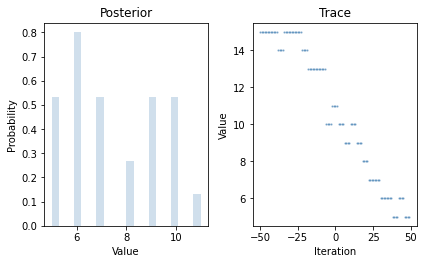

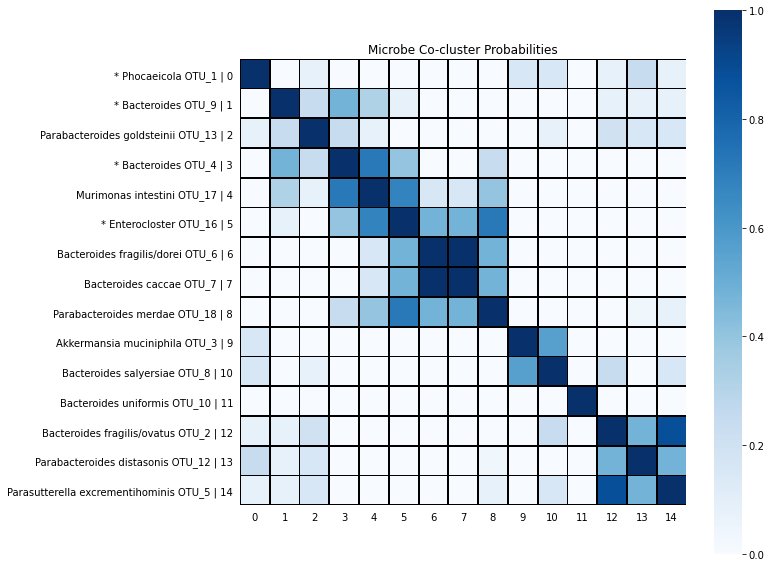

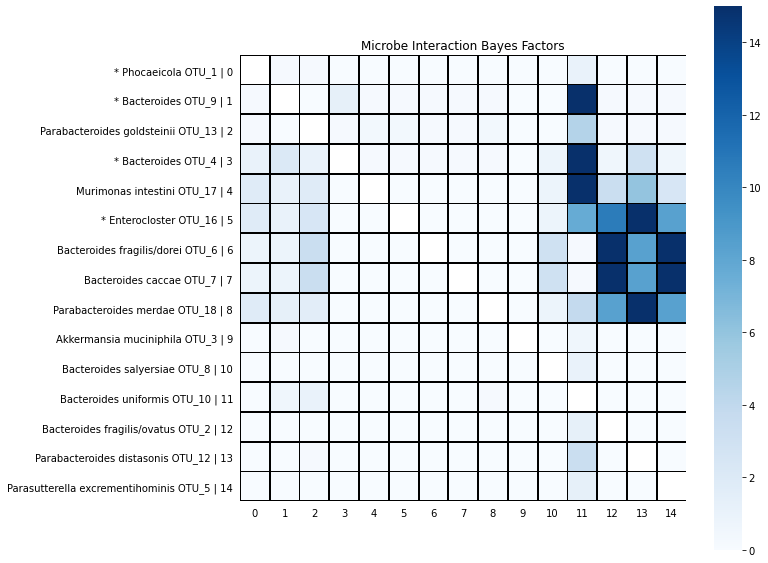

In [18]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxas = mcmc_uc0.graph.data.taxas

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxas[oidx], taxas))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_proportions(coclusters, taxas=uc_toy.taxas,
    yticklabels='%(paperformat)s | %(index)s', order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc0)
md2.visualization.render_bayes_factors(
    bayes_factors, taxas=taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)
plt.show()

# Calculating  $\hat{r}$

In [19]:
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/uc100', seed=100, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inte

INFO:run.369: 	perturbation High Fat Diet
INFO:run.370: 		value: {2110282181488: 0, 2110286189232: 0, 2110281817952: 0, 2110282253088: 0, 2110247310616: 0, 2110235353888: 0, 2110235354336: 0, 2110235356408: 0, 2110235327344: 0, 2110282281312: 0, 2110282281368: 0, 2110282281592: 0, 2110282281648: 0, 2110282281704: 0, 2110282281760: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2110282181488: 0, 2110286189232: 0, 2110281817952: 0, 2110282253088: 0, 2110247310616: 0, 2110235353888: 0, 2110235354336: 0, 2110235356408: 0, 2110235327344: 0, 2110282281312: 0, 2110282281368: 0, 2110282281592: 0, 2110282281648: 0, 2110282281704: 0, 2110282281760: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2110282181488: 0, 2110286189232: 0, 2110281817952: 0, 2110282253088: 0, 2110247310616: 0, 2110235353888: 0, 2110235354336: 0, 2110235356408: 0, 2110235327344: 0, 2110282281312: 0, 2110282281368: 0, 211028228159

INFO:inference.438: Cluster interaction probability: 0.6902120211131538
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.026000499725341797s
perturbation High Fat Diet (9/15): [ True  True False  True False  True False  True  True  True False  True  True False False]
perturbation Vancomycin (11/15): [False  True False  True  True  True  True  True  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True False False  True  True  True  True  True  True  True  True]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.543380172150942
	perturbation Vancomycin: 0.6541798484844479
	perturbation Gentamicin: 0.5771423101278725
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.12171643 0.39229091 0.74647098 0.36933789 0.76639724

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.24935488589151739
	perturbation Vancomycin: 0.39478510894188606
	perturbation Gentamicin: 0.0836243339418902
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.02026563 0.20128539 0.7419323  0.02047319 0.73338937 0.55885879 0.23532478 0.36486274 0.17748172 0.30274626 0.0431157  0.29107326 1.28805679 0.72884907 0.17401487]
Self Interactions:
[9.18655524e-02 1.38047429e-01 2.27791916e-01 1.17697157e+00 1.51039381e+00 4.71091481e-01 2.61297844e-01 8.71438273e-01 6.35525406e+01 1.20543130e+02 1.51028935e-01 1.08117117e+02 4.55128167e+00 1.40742205e+00 4.37614901e+00]
Interactions:
[-9.32740112e+00  4.58207766e+01  6.39503961e-01 -3.69532773e+01 -3.87413142e+01 -6.39760566e-01  4.71188349e+00  1.06267818e+00  4.21912719e+00 -4.41174488e+01  9.84841289e-02 -4.64

INFO:inference.438: Process Variance parameter: 4.657837695315136, empirical_variance: 4.58982
INFO:inference.438: Filtering: no-mp - Time: 0.2640, Acc: [0.627, 0.596, 0.604, 0.618, 0.609], data/sec: 21303.28
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 2110282181488
	members: ['OTU_1']
	size: 1
Cluster 2110286189232
	members: ['OTU_2']
	size: 1
Cluster 2110281817952
	members: ['OTU_3']
	size: 1
Cluster 2110282253088
	members: ['OTU_4']
	size: 1
Cluster 2110247310616
	members: ['OTU_5']
	size: 1
Cluster 2110235353888
	members: ['OTU_6']
	size: 1
Cluster 2110235354336
	members: ['OTU_7']
	size: 1
Cluster 2110235356408
	members: ['OTU_8']
	size: 1
Cluster 2110235327344
	members: ['OTU_9']
	size: 1
Cluster 2110282281312
	members: ['OTU_10']
	size: 1
Cluster 2110282281368
	members: ['OTU_12']
	size: 1
Cluster 2110282281592
	members: ['OTU_13']
	size: 1
Cluster 2110282281648
	members: ['OTU_16']
	siz

INFO:inference.438: Cluster interaction probability: 0.05671825787353486
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.013001680374145508s
perturbation High Fat Diet (1/15): [False False  True False False False False False False False False False False False False]
perturbation Vancomycin (0/15): [False False False False False False False False False False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08997769129193614
	perturbation Vancomycin: 0.10182442866807949
	perturbation Gentamicin: 0.13546862620523445
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.23396469 0.05071815 0.56351721 0.05928085 0.59848

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 2110287402208
	members: ['OTU_2']
	size: 1
Cluster 2110242780720
	members: ['OTU_8']
	size: 1
Cluster 2110287571488
	members: ['OTU_12']
	size: 1
Cluster 2110286189232
	members: ['OTU_4']
	size: 1
Cluster 2110235353888
	members: ['OTU_6']
	size: 1
Cluster 2110282281704
	members: ['OTU_17']
	size: 1
Cluster 2110248537112
	members: ['OTU_18']
	size: 1
Cluster 2110247435512
	members: ['OTU_1']
	size: 1
Cluster 2110235337392
	members: ['OTU_7']
	size: 1
Cluster 2110242829760
	members: ['OTU_13']
	size: 1
Cluster 2110248537840
	members: ['OTU_5']
	size: 1
Cluster 2110245330000
	members: ['OTU_9']
	size: 1
Cluster 2110282336968
	members: ['OTU_10']
	size: 1
Cluster 2110247310616
	members: ['OTU_3']
	size: 1
Cluster 2110245531320
	members: ['OTU_16']
	size: 1
no mp - Total time: 0.5420007705688477
INFO:inference.438: Clustering concentration parameter: 1454.

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004928131812494351
	perturbation Vancomycin: 0.3541261784715051
	perturbation Gentamicin: 0.00022883211266287902
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.40822786 0.4053263  0.74483026 0.19237003 0.76841722 0.38942828 0.07217007 0.53220582 0.0423464  0.0926769  0.33132262 0.38434408 1.00883701 0.33222775 0.24062899]
Self Interactions:
[  0.29294219   0.23816226   0.22359573   7.5778204    1.09237986   0.36497618   1.26934559   2.13966169  81.3510961  101.75350398   2.00967543  33.92210985   5.15312854   2.29383207   2.80851689]
Interactions:
[-2.11879501]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.25412548 -6.06073694 -1.74657622]
	 perturbation Gentamicin: []
INFO:infer

INFO:inference.438: Clustering concentration parameter: 10648.407897240846
INFO:inference.429: 

Inference iteration 10/100, time: 0.39502739906311035
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False F

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -190.7144607055121
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -52.783837112583754
	perturbation Vancomycin: 2.5915069942308806
	perturbation Gentamicin: -62.45440887837715
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2516485665337703, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.1893686517451085, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 105.06457718916595
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3621.8726765177794
	perturbation Vancomycin: 1206.154614802617
	perturbation G

INFO:inference.438: Cluster interaction probability: 0.0019274445158031929
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009963512420654297s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (4/14): [False  True  True False False False False False False False False  True False  True]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07011013220309921
	perturbation Vancomycin: 0.16380620748818467
	perturbation Gentamicin: 0.055104889347582967
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.75602092 0.46488063 0.77262157 0.2192888  0.38883758 0.17941044 

INFO:inference.438: Clustering concentration parameter: 73.66395495766841
INFO:inference.429: 

Inference iteration 15/100, time: 0.34899449348449707
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7760513036968946, Acceptance rate: 0.9375
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.3368386661413091, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 188.0511599036748
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1035.3142765885375
	perturbation Vancomycin: 2092.157323422104
	perturbation Gentamicin: 2238.5706675404717
INFO:inference.438: Process Variance parameter: 4.146097200098259, empirical_variance: 4.15540
INFO:inference.438: Filtering: no-mp - Time: 0.2500, Acc: [0.638, 0.596, 0.614, 0.620, 0.629], data/sec: 22500.21
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters:

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.015654520976383823
	perturbation Vancomycin: 0.10947679991549736
	perturbation Gentamicin: 0.009353022529677544
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56568988 0.49970138 0.37873387 0.01544803 0.38616369 0.2603832  0.30937492 0.22232761 0.01309767 0.12940161 0.55477602 0.02469984 0.92867188 0.76405234 0.05465611]
Self Interactions:
[  0.37089056   0.32831822   0.17723806   1.67395269   0.92814382   0.75517115   1.1872788    0.67886317  69.77323505 156.08986245   2.48508905  28.28494705   4.03976567   4.15262661   1.74387379]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.75800156]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the nor

INFO:inference.438: Cluster interaction probability: 0.0015366074945993618
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008008003234863281s
perturbation High Fat Diet (0/11): [False False False False False False False False False False False]
perturbation Vancomycin (1/11): [False False  True False False False False False False False False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0029601526633432373
	perturbation Vancomycin: 0.3538682123134702
	perturbation Gentamicin: 0.022304110128379354
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.67869909 0.37494339 0.34693198 0.1747931  0.67220102 0.21385047 0.25617947 0.31772376 0.10240059 0.22363682 0.6873994

INFO:inference.438: Clustering concentration parameter: 17.3294808476236
INFO:inference.429: 

Inference iteration 22/100, time: 0.3159961700439453
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False]
total time: 0.02501392364501953, n_interactions: 1/72, 0.01
INFO:inference.438: Cluster interaction probability: 0.008714657945169152
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007019519805908203s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomycin (

INFO:inference.429: 

Inference iteration 24/100, time: 0.3200070858001709
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.024994850158691406, n_interactions: 1/72, 0.01
INFO:inference.438: Cluster interaction probability: 0.014250976209526523
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008000373840332031s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomycin (1/9): [ True False False False False False False False False]
perturbati

INFO:inference.438: Clustering concentration parameter: 20.698398451789142
INFO:inference.429: 

Inference iteration 26/100, time: 0.3190326690673828
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.025023221969604492, n_interactions: 2/72, 0.03
INFO:inference.438: Cluster interaction probability: 0.005673541863842493
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007976770401000977s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomyci

INFO:inference.438: Clustering concentration parameter: 3.7197225372284213
INFO:inference.429: 

Inference iteration 28/100, time: 0.3249931335449219
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.023998022079467773, n_interactions: 2/72, 0.03
INFO:inference.438: Cluster interaction probability: 0.017990447992936143
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009038448333740234s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomyci

INFO:inference.438: Clustering concentration parameter: 8.011575350541674
INFO:inference.429: 

Inference iteration 30/100, time: 0.32100343704223633
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.020991802215576172, n_interactions: 2/56, 0.04
INFO:inference.438: Cluster interaction probability: 0.03364446557028324
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006999969482421875s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [ True False False False False False False False]
perturbation Gentamicin (0/8): [False False 

INFO:inference.438: Cluster interaction probability: 0.055787203909030865
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00803995132446289s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [ True False False False False False False False]
perturbation Gentamicin (0/8): [False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00011693934682941936
	perturbation Vancomycin: 0.1054101175248998
	perturbation Gentamicin: 0.03331515255270569
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.80454645 0.50026239 0.81923863 0.41912276 0.69150645 0.74966181 0.60875285 0.37775554 0.29213204 0.1937989  0.47352983 0.2331742  1.14936328 1.11668947 0.49737542]
Self Interac

INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007977962493896484s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (2/7): [ True False False False  True False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0014019505413877798
	perturbation Vancomycin: 0.41834507179149155
	perturbation Gentamicin: 0.03227313616376286
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.71580124 0.46896345 0.61214121 0.08470481 0.88839123 0.71440222 0.75889611 0.41391472 0.00741051 0.12691422 0.52522763 0.25839221 0.04288847 0.95421071 0.3545153 ]
Self Interactions:
[  0.45953341   0.27061269   0.23782959   2.9871312    1.83544327   0.38518625   0.9

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 2.2027151896697696
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -65.74355374239852
	perturbation Vancomycin: -59.61172477457227
	perturbation Gentamicin: 16.894530204181216
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.8311978033073188, Acceptance rate: 0.9722222222222222
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3844245178205221, Acceptance rate: 0.9722222222222222
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 203.69131818204795
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1117.6020212859776
	perturbation Vancomycin: 4065

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -7.379274334555966
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 50.83306790663619
	perturbation Vancomycin: 73.61965598319607
	perturbation Gentamicin: 232.77216151439583
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.2896159511896506, Acceptance rate: 0.9736842105263158
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7380234742973739, Acceptance rate: 0.9736842105263158
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 261.13651052842175
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1518.6135635964445
	perturbation Vancomycin: 1408.2

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -7.963555343017299
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 82.27434907078768
	perturbation Vancomycin: 23.743427991808737
	perturbation Gentamicin: -37.430602903638324
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.6663381668595587, Acceptance rate: 0.975
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.0927930753574366, Acceptance rate: 0.975
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 47.25799900207497
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4323.325384053352
	perturbation Vancomycin: 3424.844894353987
	perturbation 

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 39.14274673225949
	perturbation Vancomycin: -94.53035686563912
	perturbation Gentamicin: -107.11321640143375
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.302086200699826, Acceptance rate: 0.9761904761904762
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.1543918522459502, Acceptance rate: 0.9761904761904762
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 542.4596064159294
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 21650.207689839877
	perturbation Vancomycin: 7218.718563255619
	perturbation Gentamicin: 9655.785250379226
INFO:inference.438: Process Variance parameter: 3

INFO:inference.438: Process Variance parameter: 3.149810750917734, empirical_variance: 3.09245
INFO:inference.438: Filtering: no-mp - Time: 0.2670, Acc: [0.621, 0.597, 0.621, 0.612, 0.611], data/sec: 21067.95
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 2110282281704
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 2110245264800
	members: ['OTU_8', 'OTU_5', 'OTU_2', 'OTU_12']
	size: 4
Cluster 2110235337392
	members: ['OTU_4']
	size: 1
Cluster 2110245531320
	members: ['OTU_3', 'OTU_9']
	size: 2
Cluster 2110245500464
	members: ['OTU_1', 'OTU_13', 'OTU_18']
	size: 3
Cluster 2110242780720
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.28496599197387695
INFO:inference.438: Clustering concentration parameter: 6.395404796305354
INFO:posterior.1569: 0/15: 2
INFO:posterior.1569: 1/15: 13
INFO:posterior.1569: 2/15: 7
INFO:posterior.1569: 3/15: 10
INFO:posterior.1569: 4/15: 14
INFO:pos

INFO:inference.438: Clustering concentration parameter: 6.108585004113071
INFO:inference.429: 

Inference iteration 47/100, time: 0.3309977054595947
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.018024206161499023, n_interactions: 2/42, 0.05
INFO:inference.438: Cluster interaction probability: 0.04715855760440366
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007002353668212891s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of th

INFO:inference.438: Cluster interaction probability: 0.07931645658093951
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00800013542175293s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.001291896603221483
	perturbation Vancomycin: 0.05354003101418932
	perturbation Gentamicin: 0.12607037397694587
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.72715537 0.36314937 0.48942517 0.1730969  0.76614694 0.71192844 0.51328545 0.6352934  0.32052953 0.08239226 0.47970797 0.325411   1.01262621 1.01453683 0.45812519]
Self Interactions:
[4.74058382e-01 1.93191381e-01 1.68315412e-01 9.7

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -11.194119403291019
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 42.994959979001216
	perturbation Vancomycin: -26.993484611896054
	perturbation Gentamicin: -14.004128889027832
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.079069945936974, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3762791143053568, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 390.8281741489443
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2992.2544976375175
	perturbation Vancomycin: 7305.672931597516
	perturbation

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1465.30510915592
	perturbation Vancomycin: 14002.45076586613
	perturbation Gentamicin: 121750.05049630548
INFO:inference.438: Process Variance parameter: 2.8789033626162785, empirical_variance: 2.94433
INFO:inference.438: Filtering: no-mp - Time: 0.2540, Acc: [0.622, 0.622, 0.628, 0.620, 0.615], data/sec: 22145.45
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2110282281704
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 2110245264800
	members: ['OTU_4', 'OTU_8', 'OTU_9', 'OTU_12', 'OTU_13']
	size: 5
Cluster 2110286189232
	members: ['OTU_3', 'OTU_2', 'OTU_5', 'OTU_1', 'OTU_18']
	size: 5
Cluster 2110281969224
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.18999838829040527
INFO:inference.438: Clustering concentration par

INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0050280094146728516s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.026150778709256115
	perturbation Vancomycin: 0.09345791809758316
	perturbation Gentamicin: 0.08187362424249561
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.47299584 0.29508768 0.54559807 0.24135556 0.58948479 0.74452073 0.627884   0.51941191 0.18005163 0.23860203 0.49491766 0.14241552 1.05011106 0.94348748 0.22142904]
Self Interactions:
[4.30909956e-01 2.60103201e-01 2.44510750e-01 1.08433520e+01 1.01677042e+00 5.13902448e-01 6.10518240e-01 1.29553912e+00 1.60509189e+02 2.

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 3.940847170981766
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -58.0288788857022
	perturbation Vancomycin: -26.125345000495674
	perturbation Gentamicin: -96.99717434746162
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.0080078997223625, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.17143865133707453, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 21.081921180485278
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1222.3702738211216
	perturbation Vancomycin: 1027.342333398801
	perturbation 

INFO:inference.438: Process Variance parameter: 2.743134954494001, empirical_variance: 2.79979
INFO:inference.438: Filtering: no-mp - Time: 0.2570, Acc: [0.612, 0.634, 0.617, 0.605, 0.600], data/sec: 21883.26
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 2110282281704
	members: ['OTU_7', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 4
Cluster 2110245264800
	members: ['OTU_8', 'OTU_10', 'OTU_18']
	size: 3
Cluster 2110286189232
	members: ['OTU_13', 'OTU_3', 'OTU_1', 'OTU_4']
	size: 4
Cluster 2110281969224
	members: ['OTU_12']
	size: 1
Cluster 2110281304160
	members: ['OTU_5']
	size: 1
Cluster 2110282281368
	members: ['OTU_2', 'OTU_9']
	size: 2
no mp - Total time: 0.21600008010864258
INFO:inference.438: Clustering concentration parameter: 2.446730660617573
INFO:posterior.1569: 0/15: 7
INFO:posterior.1569: 1/15: 0
INFO:posterior.1569: 2/15: 6
INFO:posterior.1569: 3/15: 2
INFO:posterior.1569: 4/15: 12
INFO:poste

INFO:inference.438: Clustering concentration parameter: 1.6651031932528269
INFO:inference.429: 

Inference iteration 63/100, time: 0.294999361038208
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False False False False  True False False False False False False False False False False False False]
total time: 0.010979413986206055, n_interactions: 2/20, 0.10
INFO:inference.438: Cluster interaction probability: 0.239151098199553
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005023956298828125s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.03628102003527456
	perturbation Vancomycin: 0.4761556648929246
	pe

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.34175001555193096
	perturbation Vancomycin: 0.20415927313537668
	perturbation Gentamicin: 0.03310260435000608
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.99666757 0.31098328 0.49674497 0.16937374 0.80570669 0.66532688 0.41559102 0.53044507 0.31342293 0.19758567 0.40619249 0.31269574 0.96815567 0.85397197 0.42410557]
Self Interactions:
[3.99142511e-01 2.62109442e-01 1.59968196e-01 7.78769948e+00 1.29453434e+00 3.73488693e-01 7.29450210e-01 6.68877288e-01 2.71779542e+02 2.23962980e+02 2.60420125e+00 1.23396265e+02 2.76956062e+00 3.23336164e+00 4.14184507e+00]
Interactions:
[-0.11938913 -1.23329089  0.17077535 -1.49418925 -6.05125044]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 130.77573854477689
	perturbation Vancomycin: 69.67067887073033
	perturbation Gentamicin: -58.669814254347685
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0820424139980342, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.8062498638644283, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 31.114796842799006
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1146.5703282819518
	perturbation Vancomycin: 2088.5271333850856
	perturbation Gentamicin: 21244.944583200664
INFO:inference.438: Process Variance parameter: 2.631289362187709, empiri

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 387.37740335370916
	perturbation Vancomycin: 2581.833830608047
	perturbation Gentamicin: 3511.3339072362096
INFO:inference.438: Process Variance parameter: 2.6231177192069173, empirical_variance: 2.60664
INFO:inference.438: Filtering: no-mp - Time: 0.2770, Acc: [0.628, 0.631, 0.602, 0.602, 0.612], data/sec: 20304.36
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2110282281704
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 2110286189232
	members: ['OTU_1', 'OTU_3', 'OTU_8', 'OTU_4', 'OTU_10', 'OTU_18', 'OTU_13']
	size: 7
Cluster 2110281269600
	members: ['OTU_9', 'OTU_12']
	size: 2
Cluster 2110247310616
	members: ['OTU_2', 'OTU_5']
	size: 2
no mp - Total time: 0.2279682159423828
INFO:inference.438: Clustering concentration pa

INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006025075912475586s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02427989143087888
	perturbation Vancomycin: 0.12145991381436293
	perturbation Gentamicin: 0.0314980092449921
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.72167637 0.57480753 0.54706912 0.35887891 0.57146137 0.48404539 0.61387873 0.41286036 0.07252017 0.27006211 0.75502266 0.28605863 1.12666861 1.04220417 0.46182997]
Self Interactions:
[3.48594899e-01 2.82551779e-01 1.96057656e-01 1.37305630e+01 1.13571460e+00 4.21243719e-02 7.41130559e-01 1.18458824e+00 2.33304674e+02 2.745

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -2.734680173612947
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -9.085500610273552
	perturbation Vancomycin: 34.467008998606765
	perturbation Gentamicin: -73.78226033631837
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4902095035720905, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.2364409376531373, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 57.61767606606028
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3572.579211280949
	perturbation Vancomycin: 1051.6054260293772
	perturbation Ge

INFO:inference.438: Clustering concentration parameter: 2.3122631860845293
INFO:posterior.1569: 0/15: 11
INFO:posterior.1569: 1/15: 12
INFO:posterior.1569: 2/15: 14
INFO:posterior.1569: 3/15: 1
INFO:posterior.1569: 4/15: 0
INFO:posterior.1569: 5/15: 6
INFO:posterior.1569: 6/15: 10
INFO:posterior.1569: 7/15: 13
INFO:posterior.1569: 8/15: 7
INFO:posterior.1569: 9/15: 9
INFO:posterior.1569: 10/15: 3
INFO:posterior.1569: 11/15: 4
INFO:posterior.1569: 12/15: 2
INFO:posterior.1569: 13/15: 8
INFO:posterior.1569: 14/15: 5
INFO:inference.429: 

Inference iteration 77/100, time: 0.4692726135253906
INFO:inference.438: Cluster interaction indicator parameter: [ True  True False  True  True False False False False False False False]
total time: 0.00899815559387207, n_interactions: 4/12, 0.33
INFO:inference.438: Cluster interaction probability: 0.2476719332584573
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00799703598022461s
perturbation High Fat Diet (0/3

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -2.2426943265109
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -61.34846566730663
	perturbation Vancomycin: 1.2591323997252903
	perturbation Gentamicin: 19.693788187067284
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8089073075352943, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.396733748627111, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 117.70676232918048
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1400.883611769372
	perturbation Vancomycin: 957.8314625839354
	perturbation Genta

INFO:inference.438: Filtering: no-mp - Time: 0.2601, Acc: [0.612, 0.622, 0.620, 0.607, 0.592], data/sec: 21630.21
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2110282281704
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 2110286189232
	members: ['OTU_4', 'OTU_5', 'OTU_3', 'OTU_1', 'OTU_9', 'OTU_13', 'OTU_10', 'OTU_8', 'OTU_18', 'OTU_2']
	size: 10
Cluster 2110247310616
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.16994953155517578
INFO:inference.438: Clustering concentration parameter: 0.4308601541067305
INFO:inference.429: 

Inference iteration 82/100, time: 0.3039987087249756
INFO:inference.438: Cluster interaction indicator parameter: [ True  True  True  True False False]
total time: 0.007966756820678711, n_interactions: 4/6, 0.67
INFO:inference.438: Cluster interaction probability: 0.15151431579379043
INFO:inference.438: Perturbation indicator parameter: Perturbation I

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.16476509150859142
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -53.590313801763415
	perturbation Vancomycin: -11.031681649281465
	perturbation Gentamicin: 103.06608116616466
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1060454786523062, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.15045160297879, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 12.92751639502467
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9529.0328946045
	perturbation Vancomycin: 5426.436515547953
	perturbation Gent

INFO:inference.438: Filtering: no-mp - Time: 0.2700, Acc: [0.598, 0.642, 0.630, 0.621, 0.606], data/sec: 20830.81
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2110282281704
	members: ['OTU_6', 'OTU_7', 'OTU_16', 'OTU_17']
	size: 4
Cluster 2110286189232
	members: ['OTU_5', 'OTU_4', 'OTU_1', 'OTU_9', 'OTU_13', 'OTU_10', 'OTU_8', 'OTU_3', 'OTU_2', 'OTU_18']
	size: 10
Cluster 2110282281592
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.1699972152709961
INFO:inference.438: Clustering concentration parameter: 0.7477158418367703
INFO:inference.429: 

Inference iteration 87/100, time: 0.3021254539489746
INFO:inference.438: Cluster interaction indicator parameter: [ True  True  True  True False False]
total time: 0.006970643997192383, n_interactions: 4/6, 0.67
INFO:inference.438: Cluster interaction probability: 0.3726274821639971
INFO:inference.438: Perturbation indicator parameter: Perturbation Ind

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00038019622720261546
	perturbation Vancomycin: 0.07334635502494402
	perturbation Gentamicin: 0.25453134322156
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.78472049 0.44077286 0.57459345 0.09651505 0.60006248 0.83942286 0.52505933 0.4485137  0.38360541 0.10626955 0.50026533 0.22589647 1.13400481 0.97298206 0.51017093]
Self Interactions:
[4.40619764e-01 1.67602687e-01 2.56489176e-01 1.72722752e+01 9.75239384e-01 2.88812357e-01 6.74467643e-02 1.32054995e+00 1.64435778e+02 1.78524096e+02 2.63683407e+00 1.16767396e+02 1.80090082e+00 3.62421105e+00 5.73934624e+00]
Interactions:
[-0.06513149 -0.89106727  0.22426653 -1.26188001]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.11964083]
	

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -3.773324416904954
	perturbation Vancomycin: 44.88735512461526
	perturbation Gentamicin: 60.73683966298437
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.32367639427639877, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.215837145184143, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 26.980842069928297
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1720.8939297647426
	perturbation Vancomycin: 989.4021475920543
	perturbation Gentamicin: 3377.006684077328
INFO:inference.438: Process Variance parameter: 2.3573670235747515, empirical_

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2635.3211455139644
	perturbation Vancomycin: 3300.5020705761235
	perturbation Gentamicin: 2387.4966539880993
INFO:inference.438: Process Variance parameter: 2.381120216476116, empirical_variance: 2.35706
INFO:inference.438: Filtering: no-mp - Time: 0.2750, Acc: [0.608, 0.624, 0.612, 0.603, 0.613], data/sec: 20453.12
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2110282281704
	members: ['OTU_6', 'OTU_7', 'OTU_16', 'OTU_17']
	size: 4
Cluster 2110286189232
	members: ['OTU_4', 'OTU_9', 'OTU_1', 'OTU_2', 'OTU_10', 'OTU_13', 'OTU_18']
	size: 7
Cluster 2110287569248
	members: ['OTU_3', 'OTU_5', 'OTU_8']
	size: 3
Cluster 2110287034072
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.21797513961791992
INFO:inference.438: Clustering concentration p

INFO:inference.438: Cluster interaction probability: 0.21878276659948923
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008981943130493164s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (2/4): [ True False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06981898586323312
	perturbation Vancomycin: 0.14254651749137506
	perturbation Gentamicin: 0.17515023259878942
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.73728345 0.4534971  0.73281345 0.19560122 0.45705571 0.47635253 0.80890019 0.3142004  0.3718098  0.25024483 0.41690869 0.4405486  1.06159559 1.00270205 0.56668108]
Self Interactions:
[5.01834485e-01 1.30824240e-01 2.38170504e-01 7.58407556e+00 1.0173

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 2.215958532076094
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 49.68282305219673
	perturbation Vancomycin: 9.370748123262391
	perturbation Gentamicin: 24.595198711149443
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.3907147576433473, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.640512073616351, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 13.033749413873936
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2207.4836153200113
	perturbation Vancomycin: 3357.6975232236
	perturbation Gentami

INFO:util.171: Number of clusters: 4
INFO:util.177: Clusters assigned: [0 1 0 0 1 3 3 0 1 0 2 0 3 3 0]


Cluster 0
	 Bacteroides caccae OTU_7
	 Bacteroides fragilis/dorei OTU_6
	 Murimonas intestini OTU_17
	 * Enterocloster OTU_16
Cluster 1
	 * Phocaeicola OTU_1
	 Akkermansia muciniphila OTU_3
	 * Bacteroides OTU_4
	 Bacteroides salyersiae OTU_8
	 Bacteroides uniformis OTU_10
	 Parabacteroides goldsteinii OTU_13
	 Parabacteroides merdae OTU_18
Cluster 2
	 * Bacteroides OTU_9
	 Bacteroides fragilis/ovatus OTU_2
	 Parasutterella excrementihominis OTU_5
Cluster 3
	 Parabacteroides distasonis OTU_12


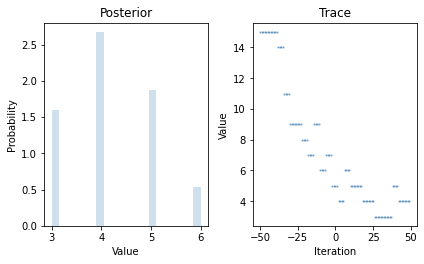

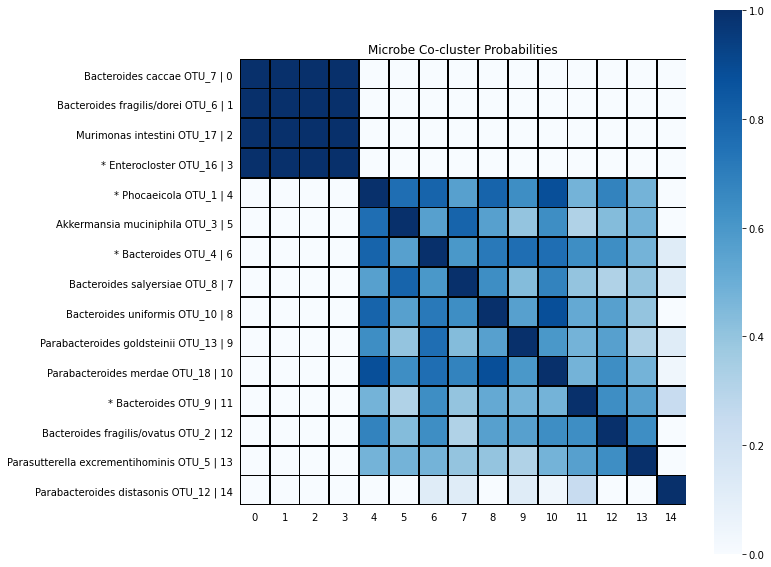

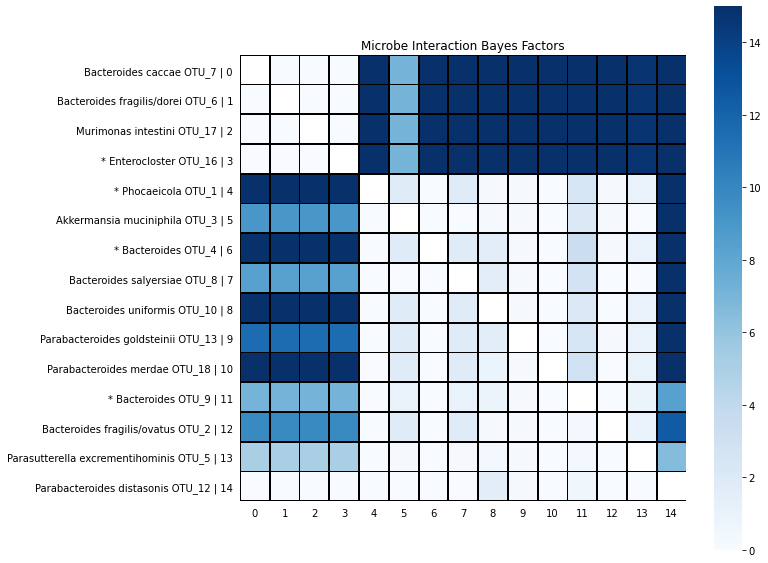

In [20]:
clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxas = mcmc_uc1.graph.data.taxas

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxas[oidx], taxas))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_proportions(
    coclusters, taxas=uc_toy.taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc1)
md2.visualization.render_bayes_factors(
    bayes_factors, taxas=taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)

plt.show()

In [21]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth values:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter:', rhat)


Growth values: [1.2258782  0.7140771  0.73311432 0.71064089 0.7180275  1.78382847 0.79838315 0.9757258  0.79322504 0.7281987  0.71792805 0.86872278 0.80161461 0.81470792 0.85056498]
Concentration parameter: 1.0497237938591648
Process variance parameter: 0.7072692558004758


# Consensus clustering
Run the model with a fixed modules

In [22]:
# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = 'output/mdsine2/healthy100/mcmc.pkl'

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inte

INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2110242691504: 0, 2110242689488: 0, 2110242689768: 0, 2110242690048: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2110242691504: 0, 2110242689488: 0, 2110242689768: 0, 2110242690048: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False]
INFO:run.380: 	perturbation Vancomycin: [False False False False]
INFO:run.380: 	perturbation Gentamicin: [False False False False]
INFO:run.381: Perturbation indicator probability:
INFO:run.383: 	perturbation High Fat Diet
INFO:run.384: 		value: 0.1527842458791

INFO:inference.438: Process Variance parameter: 4.508615875884723, empirical_variance: 4.51137
INFO:inference.438: Filtering: parallel
INFO:inference.429: 

Inference iteration 2/100, time: 0.3130002021789551
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False  True False False False False  True False]
total time: 0.01196908950805664, n_interactions: 2/12, 0.17
INFO:inference.438: Cluster interaction probability: 0.03206175420693834
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0060002803802490234s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [False False False  True]
perturbation Gentamicin (1/4): [ True False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.01813654527280382
	perturbation Vancomycin: 0.11605092380135008
	pertu

INFO:inference.438: Process Variance parameter: 4.682663674190299, empirical_variance: 4.53677
INFO:inference.438: Filtering: no-mp - Time: 0.2500, Acc: [0.618, 0.584, 0.620, 0.622, 0.629], data/sec: 22499.29
INFO:inference.429: 

Inference iteration 5/100, time: 0.3090016841888428
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False  True]
total time: 0.009982824325561523, n_interactions: 1/12, 0.08
INFO:inference.438: Cluster interaction probability: 0.13221759805390618
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00600123405456543s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [False False False  True]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet:

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1714.3217332319618
	perturbation Vancomycin: 2821.646153997795
	perturbation Gentamicin: 1157.6871707023631
INFO:inference.438: Process Variance parameter: 4.3043504791845315, empirical_variance: 4.46732
INFO:inference.438: Filtering: no-mp - Time: 0.2660, Acc: [0.650, 0.599, 0.604, 0.605, 0.605], data/sec: 21146.48
INFO:inference.429: 

Inference iteration 8/100, time: 0.2990150451660156
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False]
total time: 0.008000612258911133, n_interactions: 0/12, 0.00
INFO:inference.438: Cluster interaction probability: 0.0999639240751676
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0050165653228759766s
perturbation High Fat Diet (0/4): [False False False False]
perturbation

INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.5681870467284724, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 109.5722012836098
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 445.84168767156723
	perturbation Vancomycin: 8906.360480120531
	perturbation Gentamicin: 49274.93481831796
INFO:inference.438: Process Variance parameter: 4.4128447467859715, empirical_variance: 4.38535
INFO:inference.438: Filtering: no-mp - Time: 0.2620, Acc: [0.626, 0.596, 0.616, 0.637, 0.640], data/sec: 21468.83
INFO:inference.429: 

Inference iteration 11/100, time: 0.2989921569824219
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False]
total time: 0.007998466491699219, n_interactions: 0/12, 0

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1386694262497563, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.633627077254168, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 375.58780990239643
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 624.4552717147798
	perturbation Vancomycin: 899.0316825764014
	perturbation Gentamicin: 871.4544913291584
INFO:inference.438: Process Variance parameter: 4.312870451824697, empirical_variance: 4.24770
INFO:inference.438: Filtering: no-mp - Time: 0.2630, Acc: [0.621, 0.641, 0.620, 0.634, 0.637], data/sec: 21387.04
INFO:inference.429: 

Inference iteration 14/100, time: 0.2949953079223633
INFO:inference.438: Cluster interaction indicator param

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 91.73278726824816
	perturbation Vancomycin: 22.141083092616757
	perturbation Gentamicin: 18.961501874273704
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.775982412075604, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.775547319694893, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 735.0165560869799
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 986.3439724794539
	perturbation Vancomycin: 4260.161764180351
	perturbation Gentamicin: 497.7345783600422
INFO:inference.438: Process Variance parameter: 3.9308900950100627, empirical_vari

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 2.340338324285856
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -74.09230317593334
	perturbation Vancomycin: -21.105880627002072
	perturbation Gentamicin: 71.93460210398707
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.735386871529367, Acceptance rate: 0.9473684210526315
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.8398580236635356, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 121.4328731976534
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1138.2675902508572
	perturbation Vancomycin: 676.8249608711079
	per

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -4.6902047590702916
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 107.5083061914619
	perturbation Vancomycin: 21.810525274842625
	perturbation Gentamicin: -0.7801184710661433
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9599301128785086, Acceptance rate: 0.9545454545454546
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.161690393621078, Acceptance rate: 0.9545454545454546
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 73.1580716504487
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1889.842782475316
	perturbation Vancomycin: 5263.98

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 5.567857808913509
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -27.183489061157413
	perturbation Vancomycin: -75.31233413791634
	perturbation Gentamicin: 23.016883477084775
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8156833193189991, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.554403178739215, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 36.58951476793211
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1341.8557976010622
	perturbation Vancomycin: 4875.1203465134495
	perturbation G

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -3.674102605327771
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -113.94727104680446
	perturbation Vancomycin: 5.955930173141389
	perturbation Gentamicin: -50.2332423386623
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.212570131247598, Acceptance rate: 0.9642857142857143
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.493387380158662, Acceptance rate: 0.9642857142857143
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 19.215742436504872
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 52226.945671461224
	perturbation Vancomycin: 818.213

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.1558503293325651
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 268.6758592828093
	perturbation Vancomycin: -107.413749691982
	perturbation Gentamicin: 43.430822461117096
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5238672329742775, Acceptance rate: 0.967741935483871
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.040877560336643, Acceptance rate: 0.967741935483871
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 49.736667668793935
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1756.2171577078034
	perturbation Vancomycin: 10646.453

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -2.224338733417726
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -93.68965829041264
	perturbation Vancomycin: 34.82585432800546
	perturbation Gentamicin: -83.39075052267717
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.297716084781994, Acceptance rate: 0.9705882352941176
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.641415330918363, Acceptance rate: 0.9705882352941176
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 82.54069397365573
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2330.136160843217
	perturbation Vancomycin: 2473.2871

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.5853211250052206
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -44.02307032434011
	perturbation Vancomycin: 39.3447123903479
	perturbation Gentamicin: 66.4946981128951
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.49293683992619985, Acceptance rate: 0.972972972972973
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.1976925123156987, Acceptance rate: 0.972972972972973
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 64.24491664268288
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 521.4156257354439
	perturbation Vancomycin: 1760.603218

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 8.294315424447648
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -145.9416991879035
	perturbation Vancomycin: 3.792041898149921
	perturbation Gentamicin: 91.41623674905873
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7821750470039807, Acceptance rate: 0.975
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3453611389460725, Acceptance rate: 0.975
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 463.8841788040327
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1087.6454385558568
	perturbation Vancomycin: 938.2324376372599
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -0.7266916649760071
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 0.2353264490822149
	perturbation Vancomycin: -49.62396137446086
	perturbation Gentamicin: -38.923221339792036
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4386263593230598, Acceptance rate: 0.9767441860465116
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7280719785361967, Acceptance rate: 0.9767441860465116
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 34.70170790673226
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4705.888499546853
	perturbation Vancomycin: 1634

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 3.774114466283207
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -45.98059502744171
	perturbation Vancomycin: 29.88286961212018
	perturbation Gentamicin: 48.38471886930611
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.3141725470117738, Acceptance rate: 0.9782608695652174
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.0930135179884273, Acceptance rate: 0.9782608695652174
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 85.16260899534772
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2717.233771821176
	perturbation Vancomycin: 2321.5436

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -1.701327008651844
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -0.3086477699249788
	perturbation Vancomycin: 7.435199709357313
	perturbation Gentamicin: -10.783577988199209
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6139232855826346, Acceptance rate: 0.9795918367346939
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.043771272921345, Acceptance rate: 0.9795918367346939
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 27.357353887843026
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3208.7158438471974
	perturbation Vancomycin: 1036

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.6362958187293554
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 54.43548782853931
	perturbation Vancomycin: 38.3321630191143
	perturbation Gentamicin: -54.72027440095443
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8431573601947177, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.171633007158824, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 10.948938849815699
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 6195.331217189229
	perturbation Vancomycin: 3966.8089717419575
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 2.008671052850001
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 150.95769579226638
	perturbation Vancomycin: -6.589293355340249
	perturbation Gentamicin: -89.03415323551732
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7904318662012642, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.50890962069695, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 17.131955300135953
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 15558.642847292771
	perturbation Vancomycin: 1081.595304966174
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.5761269068453918
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -92.03095152494392
	perturbation Vancomycin: 57.04860809569276
	perturbation Gentamicin: 27.622146961376984
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7324693737664832, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.743011331507634, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 32.80196447419795
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 11118.283193045945
	perturbation Vancomycin: 8256.224782364843
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.6661287658027806
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 108.16517526446843
	perturbation Vancomycin: 0.4370161655323139
	perturbation Gentamicin: 3.798678175943694
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9478314010393631, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.2016376212460194, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 30.119484044318824
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2332.5519249200815
	perturbation Vancomycin: 4717.3848489633
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 3.662489368219689
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 5.699420158396817
	perturbation Vancomycin: -27.394203812678406
	perturbation Gentamicin: -15.048010696566966
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9773948730598347, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.6597358106783657, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 31.437353059987938
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 18168.212067901262
	perturbation Vancomycin: 2072.231707819543
	perturbation 

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 3.424840038867353
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 105.95965673425644
	perturbation Vancomycin: -5.214812836852443
	perturbation Gentamicin: 20.922825764621564
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7732703566322171, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.8906372023251405, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 58.381444779286056
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4296.259373402989
	perturbation Vancomycin: 1613.137622669292
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 4.627726076262324
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -48.532644086389936
	perturbation Vancomycin: 19.438115179420993
	perturbation Gentamicin: 26.99042983580582
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8159346445579507, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.1136985964722794, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 21.1443624901674
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1185.6968499180443
	perturbation Vancomycin: 1099.42451744531
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -3.0127721532418588
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 129.00635289629932
	perturbation Vancomycin: 43.57892175279376
	perturbation Gentamicin: -42.0760867559042
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0903115468057656, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.6747652984793393, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 28.516954950323928
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1428.5768073427237
	perturbation Vancomycin: 2754.6404790281053
	perturbation G

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.3502702616199873
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -30.374029002274476
	perturbation Vancomycin: -8.563014289498694
	perturbation Gentamicin: 23.227129798367606
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5933938449797675, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.062153644364231, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 19.612094155425815
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2008.6257369750094
	perturbation Vancomycin: 9182.955425080845
	perturbation G

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.5498468871147171
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -17.111920874145177
	perturbation Vancomycin: -0.6210359742085955
	perturbation Gentamicin: 45.815298026328165
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4318059833280474, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.651425261813413, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 16.7731063554448
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1002.546167514362
	perturbation Vancomycin: 931.0487849659846
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -1.176692507903838
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 8.720753041253564
	perturbation Vancomycin: 63.21052170049904
	perturbation Gentamicin: 71.54325231944395
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.71967720509465, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7014970524934316, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 18.633578722288746
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5195.995811036827
	perturbation Vancomycin: 1217.7318577695082
	perturbation Gentam

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -0.8954038690929593
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 72.278615097083
	perturbation Vancomycin: 126.87596386257857
	perturbation Gentamicin: 123.80130327001298
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.731670899033763, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7951557252019004, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 19.775980067225078
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5479.46192040403
	perturbation Vancomycin: 12775.185899162938
	perturbation Genta

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 4.397596582029604
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -42.288090765769745
	perturbation Vancomycin: 9.528533110370748
	perturbation Gentamicin: 15.105864468659231
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.126245464195472, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.9650886065411188, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 59.750707772768095
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2625.6319298250487
	perturbation Vancomycin: 1595.284906439324
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -4.604283437874149
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 138.9283785358844
	perturbation Vancomycin: -5.015630816341162
	perturbation Gentamicin: 6.01396690901442
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.481877041420897, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.1837740028137858, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 41.088548800653
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1839.1527520196537
	perturbation Vancomycin: 750.4254754797904
	perturbation Gentamic

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.5263839033438968
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 81.10507069938696
	perturbation Vancomycin: -4.866871951516825
	perturbation Gentamicin: -103.17855185808365
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.5489329032941463, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.8766081414965472, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 19.507994199193934
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1258.6615571071109
	perturbation Vancomycin: 1086.3555933693447
	perturbation 

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -1.9407705593393414
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 84.81212833947204
	perturbation Vancomycin: -34.7714004259565
	perturbation Gentamicin: 5.8285997398694285
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.817518962130223, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.426602209829953, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 66.11067386248554
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 7050.873218027338
	perturbation Vancomycin: 5055.645981761499
	perturbation Gentam

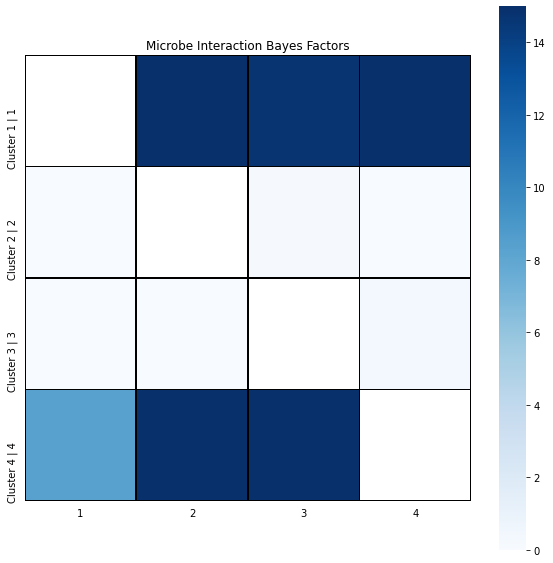

In [23]:
# Plot the posterior
taxas = mcmc.graph.data.taxas

clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation

Take out a single subject and use that as initial conditions for forward simulation

In [26]:
# Make the data and validation Study objects
study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy='data/uc-toy/taxonomy.tsv', 
    reads='data/uc-toy/reads.tsv', 
    qpcr='data/uc-toy/qpcr.tsv', 
    perturbations='data/uc-toy/perturbations.tsv', 
    metadata='data/uc-toy/metadata.tsv')

val = study.pop_subject('8')
val.name += '-validate'

print(study.name)
for subj in study:
    print(subj.name)
for pert in study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting


uc-toy-dataset
10
6
7
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)


unnamed-study-validate
8
Perturbation High Fat Diet:
	Subject 8: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 8: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 8: (50.5, 57.5)



In [27]:
# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/cv/'+study.name, seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=study.name, subjset=study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 297 qPCR measurements for 3 buckets. Each bucket is 99 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inter

INFO:run.369: 	perturbation High Fat Diet
INFO:run.370: 		value: {2110281270552: 0, 2110247359824: 0, 2110247358592: 0, 2110246428288: 0, 2110282419784: 0, 2110287595000: 0, 2110287595896: 0, 2110287596120: 0, 2110229639296: 0, 2110248534424: 0, 2110245311488: 0, 2110245312608: 0, 2110245312832: 0, 2110245313168: 0, 2110245313560: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2110281270552: 0, 2110247359824: 0, 2110247358592: 0, 2110246428288: 0, 2110282419784: 0, 2110287595000: 0, 2110287595896: 0, 2110287596120: 0, 2110229639296: 0, 2110248534424: 0, 2110245311488: 0, 2110245312608: 0, 2110245312832: 0, 2110245313168: 0, 2110245313560: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2110281270552: 0, 2110247359824: 0, 2110247358592: 0, 2110246428288: 0, 2110282419784: 0, 2110287595000: 0, 2110287595896: 0, 2110287596120: 0, 2110229639296: 0, 2110248534424: 0, 2110245311488: 0, 211024531260

INFO:inference.438: Cluster interaction probability: 0.5907630856509913
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0240018367767334s
perturbation High Fat Diet (9/15): [False  True False  True  True False  True  True  True  True False  True  True False False]
perturbation Vancomycin (10/15): [False  True False  True  True  True  True False  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True  True False  True False  True  True  True  True  True  True]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.5032813527614807
	perturbation Vancomycin: 0.606532764595715
	perturbation Gentamicin: 0.65283684507178
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.16729313 0.38474118 0.65715856 0.37039815 0.60867957 0.4

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.10972506 0.21148443 0.43925925 0.34365468 0.67488577 0.70132305 0.28162154 0.30065323 0.29477391 0.29784929 0.33265642 0.45148658 1.44128478 0.78970728 0.06458668]
Self Interactions:
[1.32745348e-01 1.23881716e-01 1.78659679e-01 5.65656439e-01 1.17473680e+00 1.03254784e+00 4.13167191e-02 6.53079735e-01 3.72199788e+01 8.73839888e+01 3.22004535e-01 8.53225905e+01 3.68086562e+00 1.39783576e+00 1.65678417e+00]
Interactions:
[-77.49646579  67.48763089   5.15166016   0.57347955   3.37905664 -44.02942331   0.11516085  49.23850219  -6.09884891 -30.41495227 -54.69767729  -1.68261957  10.86261459   0.29298456  -2.09105291  28.21435316  -1.30003362  23.36454725  -3.20815841 -16.97049929 -45.63522185   3.62333115 -43.06296863 -18.94839314  -3.82427379 -21.95339478  14.28409504  67.11968828  -2.19732424   9.90394752   8.9801119    2.29255911  55.01367056 -30.35258535  -1.59735015 -55.3

INFO:inference.438: Clustering concentration parameter: 1028.3260132447924
INFO:inference.429: 

Inference iteration 4/100, time: 0.35423970222473145
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -59.56548232362257
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 112.77836301278023
	perturbation Vancomycin: 43.758547237931694
	perturbation Gentamicin: 103.29891945199456
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.8426204778425026, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.07471409926827421, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 347.43075185696097
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 821.7305222884659
	perturbation Vancomycin: 1836.3085429804175
	perturbation G

INFO:inference.438: Cluster interaction probability: 0.0018577960620059617
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.011031627655029297s
perturbation High Fat Diet (2/15): [False False False False False  True False False  True False False False False False False]
perturbation Vancomycin (3/15): [False False False False False False  True  True False False False False False False  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1086956386411362
	perturbation Vancomycin: 0.0897347436348209
	perturbation Gentamicin: 0.03532776678325556
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.50037082 0.52311915 0.20572461 0.15906428 0.37729

INFO:inference.438: Clustering concentration parameter: 140.9078225950882
INFO:posterior.1569: 0/15: 2
INFO:posterior.1569: 1/15: 7
INFO:posterior.1569: 2/15: 3
INFO:posterior.1569: 3/15: 6
INFO:posterior.1569: 4/15: 1
INFO:posterior.1569: 5/15: 13
INFO:posterior.1569: 6/15: 8
INFO:posterior.1569: 7/15: 0
INFO:posterior.1569: 8/15: 5
INFO:posterior.1569: 9/15: 4
INFO:posterior.1569: 10/15: 14
INFO:posterior.1569: 11/15: 9
INFO:posterior.1569: 12/15: 10
INFO:posterior.1569: 13/15: 11
INFO:posterior.1569: 14/15: 12
INFO:inference.429: 

Inference iteration 9/100, time: 0.7928709983825684
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -66.69836082858919
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -18.680954083890892
	perturbation Vancomycin: -36.24568792925337
	perturbation Gentamicin: 50.46942130462113
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.44010924033125, Acceptance rate: 0.9
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5799708116413829, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 15287.743242553692
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2261.321099367641
	perturbation Vancomycin: 2229.1558002775573
	perturbation Gent

INFO:inference.438: Cluster interaction probability: 5.139356877196297e-06
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000062942504883s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (2/14): [ True False False False False False False False False False False False False  True]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004181017733358052
	perturbation Vancomycin: 0.05229926968925037
	perturbation Gentamicin: 0.024957161353312243
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.36494258 0.18792159 0.45779191 0.13787616 0.48454079 0.05839657

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 2110282884096
	members: ['OTU_16', 'OTU_17']
	size: 2
Cluster 2110286090312
	members: ['OTU_7']
	size: 1
Cluster 2110239600768
	members: ['OTU_12']
	size: 1
Cluster 2110282067136
	members: ['OTU_8']
	size: 1
Cluster 2110282885608
	members: ['OTU_18']
	size: 1
Cluster 2110282807000
	members: ['OTU_10']
	size: 1
Cluster 2110269026544
	members: ['OTU_9']
	size: 1
Cluster 2110282721544
	members: ['OTU_3']
	size: 1
Cluster 2110269155592
	members: ['OTU_4']
	size: 1
Cluster 2110282179752
	members: ['OTU_13']
	size: 1
Cluster 2110233865408
	members: ['OTU_6']
	size: 1
Cluster 2110239540784
	members: ['OTU_5']
	size: 1
Cluster 2110240620616
	members: ['OTU_2']
	size: 1
Cluster 2110229753024
	members: ['OTU_1']
	size: 1
no mp - Total time: 0.46900177001953125
INFO:inference.438: Clustering concentration parameter: 221.04826133462552
INFO:inference.429: 

Infer

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -89.67890815449562
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -206.8937637290207
	perturbation Vancomycin: 14.764775951921571
	perturbation Gentamicin: -118.75539872717329
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.2460380167330176, Acceptance rate: 0.9333333333333333
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.3896674808254445, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 23.320637164415075
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1158.5997931837164
	perturbation Vancomycin: 1562.4735628820972

INFO:inference.438: Cluster interaction probability: 0.004598881086415299
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008999824523925781s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [ True False False False False False False False False False False False False]
perturbation Gentamicin (5/13): [False  True False False False False  True  True False False  True False  True]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0001679027614001275
	perturbation Vancomycin: 0.040940989041821405
	perturbation Gentamicin: 0.20483779375635303
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.38031175 0.35571831 0.38179046 0.20911108 0.55986299 0.06095593 0.43348154 0.2411

INFO:inference.438: Clustering concentration parameter: 46.61425751118004
INFO:inference.429: 

Inference iteration 19/100, time: 0.29898977279663086
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 11076.589562264937
	perturbation Vancomycin: 7074.740200322559
	perturbation Gentamicin: 4557.510936103714
INFO:inference.438: Process Variance parameter: 4.107334236719334, empirical_variance: 4.04363
INFO:inference.438: Filtering: no-mp - Time: 0.2270, Acc: [0.642, 0.605, 0.628, 0.588], data/sec: 19823.39
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 2110282884096
	members: ['OTU_16', 'OTU_17']
	size: 2
Cluster 2110229639296
	members: ['OTU_6']
	size: 1
Cluster 2110235398384
	members: ['OTU_4']
	size: 1
Cluster 2110245156288
	members: ['OTU_1', 'OTU_8']
	size: 2
Cluster 2110241787352
	members: ['OTU_2']
	size: 1
Cluster 2110248622176
	members: ['OTU_3']
	size: 1
Cluster 2110240620616
	members: ['OTU_18']
	size: 1
Cluster 2110269155592
	me

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -63.60820902527332
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 45.21295744058356
	perturbation Vancomycin: 9.27388757770317
	perturbation Gentamicin: 199.78078363153242
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.7123593829908097, Acceptance rate: 0.9545454545454546
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6435142506703988, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 12.201632508856658
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 911.6287019854049
	perturbation Vancomycin: 1548.7795627847242
	per

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -67.17839449163391
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -65.7971279085503
	perturbation Vancomycin: -18.547643942691092
	perturbation Gentamicin: 266.3323217657001
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.9141338898020208, Acceptance rate: 0.9583333333333334
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9009530891351063, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 29.177164671899128
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4139.500462513428
	perturbation Vancomycin: 12088.375041007544
	p

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 115.7980811124892
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -19.99916245963523
	perturbation Vancomycin: 9.828786475772267
	perturbation Gentamicin: -131.28380805563688
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.005938399508572, Acceptance rate: 0.9615384615384616
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9322822751797336, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 72.76751813511395
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 18851.84769746613
	perturbation Vancomycin: 9107.540225462266
	pert

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2110282884096
	members: ['OTU_6', 'OTU_17', 'OTU_16']
	size: 3
Cluster 2110248647312
	members: ['OTU_2', 'OTU_3', 'OTU_9', 'OTU_10', 'OTU_18']
	size: 5
Cluster 2110248620496
	members: ['OTU_1', 'OTU_5', 'OTU_12']
	size: 3
Cluster 2110269155872
	members: ['OTU_7', 'OTU_13']
	size: 2
Cluster 2110282256224
	members: ['OTU_4', 'OTU_8']
	size: 2
no mp - Total time: 0.2889978885650635
INFO:inference.438: Clustering concentration parameter: 1.1739333826070526
INFO:posterior.1569: 0/15: 12
INFO:posterior.1569: 1/15: 6
INFO:posterior.1569: 2/15: 14
INFO:posterior.1569: 3/15: 11
INFO:posterior.1569: 4/15: 10
INFO:posterior.1569: 5/15: 5
INFO:posterior.1569: 6/15: 4
INFO:posterior.1569: 7/15: 0
INFO:posterior.1569: 8/15: 9
INFO:posterior.1569: 9/15: 3
INFO:posterior.1569: 10/15: 13
INFO:posterior.1569: 11/15: 8
INFO:posterior.1569: 12/15: 1
INFO:posterior.1569: 1

INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0070095062255859375s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 2.3395762821247986e-06
	perturbation Vancomycin: 0.16705983168913707
	perturbation Gentamicin: 0.046651600874165
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[1.15273715 0.41832877 0.77736346 0.3250499  0.58585994 0.60849313 0.24288577 0.72956715 0.00535851 0.0957223  0.29618618 0.10783265 1.33147387 0.94171392 0.24941508]
Self Interactions:
[5.71874920e-01 2.31364643e-01 3.29274274e-01 8.71043653e+00 1.31917609e+00 3.32173961e-01 1.71504280e+00 1.50363680e+00 1.16106889e+02 2.

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 18.237430051929504
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -132.41462733987365
	perturbation Vancomycin: -44.410593514042546
	perturbation Gentamicin: 102.57615480420984
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.23481042645989736, Acceptance rate: 0.9696969696969697
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.285113496915003, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 989.7737588574174
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 35909.18419537703
	perturbation Vancomycin: 1825.8670678918768


INFO:inference.438: Clustering concentration parameter: 0.33780544253874145
INFO:inference.429: 

Inference iteration 36/100, time: 0.24799728393554688
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False False False]
total time: 0.007951736450195312, n_interactions: 1/6, 0.17
INFO:inference.438: Cluster interaction probability: 0.13210470341523417
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005034685134887695s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.23849440132414615
	perturbation Vancomycin: 0.2408862505679239
	perturbation Gentamicin: 0.0040272134910564646
INFO:inference.438: Logistic growth parameters (growth, self-interactio

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 4.989370163086008
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -222.96027942324633
	perturbation Vancomycin: -76.81311712597689
	perturbation Gentamicin: -68.27484151558923
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8757950952431884, Acceptance rate: 0.9473684210526315
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.2003223133148615, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 16.535001945780238
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1654.5948953420423
	perturbation Vancomycin: 5257.544553257449
	

INFO:inference.438: Clustering concentration parameter: 0.5632241860279559
INFO:posterior.1569: 0/15: 5
INFO:posterior.1569: 1/15: 10
INFO:posterior.1569: 2/15: 9
INFO:posterior.1569: 3/15: 4
INFO:posterior.1569: 4/15: 0
INFO:posterior.1569: 5/15: 7
INFO:posterior.1569: 6/15: 14
INFO:posterior.1569: 7/15: 2
INFO:posterior.1569: 8/15: 1
INFO:posterior.1569: 9/15: 13
INFO:posterior.1569: 10/15: 6
INFO:posterior.1569: 11/15: 3
INFO:posterior.1569: 12/15: 11
INFO:posterior.1569: 13/15: 12
INFO:posterior.1569: 14/15: 8
INFO:inference.429: 

Inference iteration 41/100, time: 0.39699864387512207
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False False False]
total time: 0.0069963932037353516, n_interactions: 1/6, 0.17
INFO:inference.438: Cluster interaction probability: 0.13846786056138605
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.004996538162231445s
perturbation High Fat Diet (0/4): [False False False False]
per

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.63037933 0.3425488  0.27305714 0.2892775  0.38337493 0.88309426 0.26400176 0.38661269 0.31020811 0.17352059 0.27313302 0.1586463  1.13887091 1.08399438 0.40038012]
Self Interactions:
[  0.45429028   0.1989035    0.17881981   4.68292082   0.91416575   0.60488864   1.76328255   1.23956104 108.78421867 175.30482183   1.65958883  84.32587494   2.72582863   2.92240742   5.01325217]
Interactions:
[-0.14370167]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.42229975]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -6.964000192247464
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -7.745054657048817
	perturbation Vancomycin: -81.263021917832

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.779532680028665, Acceptance rate: 0.9555555555555556
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.540774576190797, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 41.92033340627875
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2884.638080269095
	perturbation Vancomycin: 2175.9164611398937
	perturbation Gentamicin: 542.9781748794447
INFO:inference.438: Process Variance parameter: 3.206723114685522, empirical_variance: 3.25399
INFO:inference.438: Filtering: no-mp - Time: 0.2130, Acc: [0.626, 0.603, 0.603, 0.584], data/sec: 21128.53
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_cluster

INFO:inference.438: Clustering concentration parameter: 2.0617454698410116
INFO:inference.429: 

Inference iteration 48/100, time: 0.24500107765197754
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False False False False  True  True False False False]
total time: 0.0060291290283203125, n_interactions: 3/12, 0.25
INFO:inference.438: Cluster interaction probability: 0.32931310583713286
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005034208297729492s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.05412816299781525
	perturbation Vancomycin: 0.1646127872095608
	perturbation Gentamicin: 0.09170828685081353
INFO:inference.438

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.68632615 0.69045542 0.61270884 0.36068278 0.64698512 1.07246928 0.1835415  0.4927283  0.33949942 0.01657682 0.33776404 0.11967133 1.07492629 0.99116971 0.16950465]
Self Interactions:
[  0.35490131   0.24301363   0.2365362    6.33766396   1.00391496   0.57691179   1.86124731   0.89116031 108.30175204 184.74790923   1.92687392 110.46964237   1.25999785   3.41424161   2.31411751]
Interactions:
[-0.14446274 -0.73672332]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.43217712]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 8.116854668146988
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 66.68440344064288
	perturbation Vancomycin: -40.06

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1925.622960010293
	perturbation Vancomycin: 899.8856320076261
	perturbation Gentamicin: 1062.5880330742493
INFO:inference.438: Process Variance parameter: 2.9253161756008796, empirical_variance: 2.92507
INFO:inference.438: Filtering: no-mp - Time: 0.2120, Acc: [0.606, 0.632, 0.606, 0.627], data/sec: 21223.35
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2110282884096
	members: ['OTU_6', 'OTU_16', 'OTU_17']
	size: 3
Cluster 2110248620496
	members: ['OTU_10', 'OTU_7', 'OTU_3', 'OTU_13']
	size: 4
Cluster 2110282256224
	members: ['OTU_1', 'OTU_2', 'OTU_4', 'OTU_5', 'OTU_8', 'OTU_9', 'OTU_18']
	size: 7
Cluster 2110241787352
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.17400813102722168
INFO:inference.438: Clustering concentration parameter

INFO:inference.438: Clustering concentration parameter: 1.739622242190951
INFO:inference.429: 

Inference iteration 55/100, time: 0.25911545753479004
INFO:inference.438: Cluster interaction indicator parameter: [False  True  True  True  True False False False  True False False False]
total time: 0.010020732879638672, n_interactions: 5/12, 0.42
INFO:inference.438: Cluster interaction probability: 0.3754777378000777
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007016658782958984s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.007482155505160956
	perturbation Vancomycin: 0.2405299560621664
	perturbation Gentamicin: 0.0590548404055025
INFO:inference.438: L

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62592053 0.50584223 0.65710818 0.25983237 0.53913338 0.92642343 0.46533093 0.28106857 0.34607712 0.00176505 0.41289344 0.15870178 1.01099626 1.14139707 0.44750893]
Self Interactions:
[3.56007455e-01 1.76582576e-01 1.87438102e-01 1.12077513e+01 1.00597230e+00 2.42757421e-01 1.82082721e+00 8.93775509e-01 1.94437533e+02 2.09903463e+02 2.54184207e+00 1.15321767e+02 2.32267932e+00 4.33192742e+00 3.28845203e+00]
Interactions:
[-0.15338024  0.26269782 -0.05807369 -0.94737139  0.05244102]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.02369434]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -0.9519192864047817
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbati

INFO:inference.438: Process Variance parameter: 2.8765529259130744, empirical_variance: 2.89236
INFO:inference.438: Filtering: no-mp - Time: 0.2060, Acc: [0.618, 0.624, 0.612, 0.648], data/sec: 21844.88
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2110282884096
	members: ['OTU_6', 'OTU_16', 'OTU_17']
	size: 3
Cluster 2110248620496
	members: ['OTU_3', 'OTU_4', 'OTU_7', 'OTU_13', 'OTU_10', 'OTU_9', 'OTU_8']
	size: 7
Cluster 2110282256224
	members: ['OTU_1', 'OTU_2', 'OTU_5', 'OTU_12', 'OTU_18']
	size: 5
no mp - Total time: 0.16099786758422852
INFO:inference.438: Clustering concentration parameter: 1.1032180801677263
INFO:inference.429: 

Inference iteration 60/100, time: 0.24401593208312988
INFO:inference.438: Cluster interaction indicator parameter: [False  True  True  True False False]
total time: 0.005964756011962891, n_interactions: 3/6, 0.50
INFO:inference.438: Cluster interaction probability:

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0033262349573088324
	perturbation Vancomycin: 0.17947418649515098
	perturbation Gentamicin: 0.04117892695823919
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.7671743  0.46291147 0.29427578 0.21923148 0.35257851 0.68323757 0.33359931 0.3190525  0.31487701 0.2081832  0.47726405 0.25531623 0.85543906 0.88932927 0.46992255]
Self Interactions:
[4.93972969e-01 2.47016589e-01 1.33304495e-01 7.79101007e+00 8.31750428e-01 4.79709884e-01 1.47983863e+00 1.06950699e+00 1.88862641e+02 1.84297910e+02 1.59523557e+00 1.32432590e+02 2.93134599e+00 4.35671151e+00 5.09782291e+00]
Interactions:
[-0.16865388  0.24068534 -0.08589763]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.06885918]
	 perturbat

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 18.36943542286459
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2740.2722034187905
	perturbation Vancomycin: 3391.7236347678618
	perturbation Gentamicin: 1620.6406393247826
INFO:inference.438: Process Variance parameter: 2.7759815623365274, empirical_variance: 2.81866
INFO:inference.438: Filtering: no-mp - Time: 0.2120, Acc: [0.604, 0.617, 0.611, 0.604], data/sec: 21226.95
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2110282884096
	members: ['OTU_6', 'OTU_16', 'OTU_17']
	size: 3
Cluster 2110248620496
	members: ['OTU_3', 'OTU_1', 'OTU_4', 'OTU_7', 'OTU_10', 'OTU_9', 'OTU_8', 'OTU_13', 'OTU_18']
	size: 9
Cluster 2110282256224
	members: ['OTU_5', 'OTU_2', 'OTU_12']
	size: 3
no mp - Total time: 0.1500

INFO:inference.438: Clustering concentration parameter: 4.441105993936525
INFO:inference.429: 

Inference iteration 67/100, time: 0.2570009231567383
INFO:inference.438: Cluster interaction indicator parameter: [False  True False False  True  True False False False False False False False False False False False False False False]
total time: 0.012011051177978516, n_interactions: 3/20, 0.15
INFO:inference.438: Cluster interaction probability: 0.07329065042783059
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005999088287353516s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.034716938574978144
	perturbation Vancomycin: 0.0772827055236924


INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0034480493501496596
	perturbation Vancomycin: 0.30746322874638576
	perturbation Gentamicin: 0.06301981416189234
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.57186962 0.50266045 0.71031233 0.28943128 0.48452408 0.80881123 0.30622322 0.39432788 0.10462974 0.38010363 0.39665099 0.38004758 1.08478831 0.90267614 0.43367201]
Self Interactions:
[2.08531904e-01 3.24166369e-01 1.57088322e-01 8.41430257e+00 7.59472535e-01 5.57920177e-01 8.62573383e-01 1.23495839e+00 1.81218000e+02 2.20886934e+02 2.30167319e+00 1.75129038e+02 2.47061285e+00 3.58035576e+00 2.89061438e+00]
Interactions:
[-0.27089617 -0.13054293]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.51978213]
	 perturbation Gentamic

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.542222443148598, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.33159506598546, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 15.026025365000578
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 375.9829324701529
	perturbation Vancomycin: 41589.7172476729
	perturbation Gentamicin: 1063.960382403436
INFO:inference.438: Process Variance parameter: 2.638447698772342, empirical_variance: 2.63021
INFO:inference.438: Filtering: no-mp - Time: 0.2110, Acc: [0.636, 0.612, 0.619, 0.609], data/sec: 21326.92
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 211

INFO:inference.438: Filtering: no-mp - Time: 0.2126, Acc: [0.617, 0.614, 0.635, 0.606], data/sec: 21168.84
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2110282884096
	members: ['OTU_6', 'OTU_7', 'OTU_16', 'OTU_17']
	size: 4
Cluster 2110248620496
	members: ['OTU_9', 'OTU_8', 'OTU_5', 'OTU_1', 'OTU_10', 'OTU_18', 'OTU_4', 'OTU_3']
	size: 8
Cluster 2110282256224
	members: ['OTU_13']
	size: 1
Cluster 2110245574024
	members: ['OTU_2', 'OTU_12']
	size: 2
no mp - Total time: 0.21000051498413086
INFO:inference.438: Clustering concentration parameter: 1.130903126937153
INFO:inference.429: 

Inference iteration 74/100, time: 0.2619943618774414
INFO:inference.438: Cluster interaction indicator parameter: [False False  True  True False  True False False False False False  True]
total time: 0.010036230087280273, n_interactions: 4/12, 0.33
INFO:inference.438: Cluster interaction probability: 0.2160472609753117

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.69896947 0.27532558 0.46321803 0.17669224 0.22944039 0.58789985 0.49486387 0.62044176 0.42645468 0.346219   0.57613399 0.26537392 0.84426889 1.06293111 0.48406242]
Self Interactions:
[4.93002626e-01 2.51879859e-01 2.01542845e-01 4.87722247e+00 6.85816850e-01 3.45172626e-01 3.17042160e-01 1.26299298e+00 1.71157353e+02 2.57343452e+02 2.45096974e+00 1.92477514e+02 1.93983117e+00 4.86126138e+00 5.29321758e+00]
Interactions:
[11.33448207 -0.20897225  0.2042001  -0.08898299 -0.65021634]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.43278473]
	 perturbation Gentamicin: [-1.48209164]
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -2.2788344612059928
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means


INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6432104682317108, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.063326676130662, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 18.55840159939628
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3704.598998751528
	perturbation Vancomycin: 3826.8553898701625
	perturbation Gentamicin: 9886.044822810478
INFO:inference.438: Process Variance parameter: 2.515347138759619, empirical_variance: 2.53294
INFO:inference.438: Filtering: no-mp - Time: 0.2110, Acc: [0.610, 0.604, 0.581, 0.588], data/sec: 21326.42
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 

INFO:posterior.1569: 7/15: 11
INFO:posterior.1569: 8/15: 12
INFO:posterior.1569: 9/15: 2
INFO:posterior.1569: 10/15: 6
INFO:posterior.1569: 11/15: 13
INFO:posterior.1569: 12/15: 0
INFO:posterior.1569: 13/15: 9
INFO:posterior.1569: 14/15: 8
INFO:inference.429: 

Inference iteration 81/100, time: 0.4054279327392578
INFO:inference.438: Cluster interaction indicator parameter: [False  True  True  True False False]
total time: 0.007986068725585938, n_interactions: 3/6, 0.50
INFO:inference.438: Cluster interaction probability: 0.31019692219622547
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007005453109741211s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.012753024999430899


INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -2.314243702118207
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -123.18729916485134
	perturbation Vancomycin: 60.67549208576928
	perturbation Gentamicin: -69.33020496385576
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.554613056485791, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.4015797863890493, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 26.38745943137067
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1827.6722453690757
	perturbation Vancomycin: 4278.413300451443
	perturbation Gen

INFO:inference.438: Filtering: no-mp - Time: 0.2026, Acc: [0.632, 0.628, 0.628, 0.608], data/sec: 22213.19
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2110282884096
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 2110248620496
	members: ['OTU_1', 'OTU_8', 'OTU_9', 'OTU_13', 'OTU_18', 'OTU_3', 'OTU_4']
	size: 7
Cluster 2110245574024
	members: ['OTU_2', 'OTU_12']
	size: 2
Cluster 2110245574696
	members: ['OTU_5', 'OTU_10']
	size: 2
no mp - Total time: 0.17896604537963867
INFO:inference.438: Clustering concentration parameter: 1.4566363547910488
INFO:inference.429: 

Inference iteration 86/100, time: 0.25397205352783203
INFO:inference.438: Cluster interaction indicator parameter: [False  True False  True  True False False False False False False False]
total time: 0.009033441543579102, n_interactions: 3/12, 0.25
INFO:inference.438: Cluster interaction probability: 0.10086378205136

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.7112564  0.27738878 0.60802076 0.13844458 0.59482429 0.70095619 0.45509409 0.10652576 0.21813547 0.03234951 0.61620748 0.34515747 0.81945056 1.19385446 0.18088913]
Self Interactions:
[5.43831215e-01 2.22497664e-01 1.79974107e-01 8.79193549e+00 1.13630097e+00 6.12324210e-01 2.92019790e-01 4.98175919e-01 1.98770355e+02 2.32502654e+02 2.11703625e+00 1.37797171e+02 2.68341905e+00 4.14222125e+00 3.07862804e+00]
Interactions:
[-0.22148137  0.17755548 -0.09347012]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.27341415]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.507871668052015
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -31.9199

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.14782204274476507, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.369728811779251, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 10.312008383035417
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 11030.91015314913
	perturbation Vancomycin: 3790.1003537926126
	perturbation Gentamicin: 3174.748821633535
INFO:inference.438: Process Variance parameter: 2.6498844736548253, empirical_variance: 2.56209
INFO:inference.438: Filtering: no-mp - Time: 0.2090, Acc: [0.614, 0.604, 0.628, 0.619], data/sec: 21531.19
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Clust

INFO:posterior.1569: 6/15: 1
INFO:posterior.1569: 7/15: 2
INFO:posterior.1569: 8/15: 9
INFO:posterior.1569: 9/15: 3
INFO:posterior.1569: 10/15: 8
INFO:posterior.1569: 11/15: 7
INFO:posterior.1569: 12/15: 4
INFO:posterior.1569: 13/15: 14
INFO:posterior.1569: 14/15: 11
INFO:inference.429: 

Inference iteration 93/100, time: 0.3999941349029541
INFO:inference.438: Cluster interaction indicator parameter: [False  True  True  True False False]
total time: 0.006999969482421875, n_interactions: 3/6, 0.50
INFO:inference.438: Cluster interaction probability: 0.3920271984061282
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005000591278076172s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat 

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -3.130801724450138
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -10.131542214982685
	perturbation Vancomycin: 2.8686024412833313
	perturbation Gentamicin: 80.66826774453925
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.045423825852972, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.6574901063019736, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 33.53471820881116
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5316.049916122983
	perturbation Vancomycin: 9718.590074160353
	perturbation Gent

INFO:inference.438: Filtering: no-mp - Time: 0.2010, Acc: [0.607, 0.614, 0.610, 0.603], data/sec: 22388.41
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2110282884096
	members: ['OTU_6', 'OTU_7', 'OTU_16', 'OTU_17']
	size: 4
Cluster 2110248620496
	members: ['OTU_10', 'OTU_9', 'OTU_13', 'OTU_18', 'OTU_3', 'OTU_4']
	size: 6
Cluster 2110245574024
	members: ['OTU_2', 'OTU_1', 'OTU_5', 'OTU_8', 'OTU_12']
	size: 5
no mp - Total time: 0.14899945259094238
INFO:inference.438: Clustering concentration parameter: 0.5600711421305796
INFO:inference.429: 

Inference iteration 98/100, time: 0.2550084590911865
INFO:inference.438: Cluster interaction indicator parameter: [False  True  True  True False False]
total time: 0.00701141357421875, n_interactions: 3/6, 0.50
INFO:inference.438: Cluster interaction probability: 0.3833660742395997
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators 

In [29]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, val=subj, initial_conditions=initial_conditions, times=times, 
    simulation_dt=0.01)


INFO:model.111: 5/50 - 0.29648375511169434
INFO:model.111: 10/50 - 0.2910335063934326
INFO:model.111: 15/50 - 0.33300042152404785
INFO:model.111: 20/50 - 0.2955760955810547
INFO:model.111: 25/50 - 0.3060002326965332
INFO:model.111: 30/50 - 0.292999267578125
INFO:model.111: 35/50 - 0.28699755668640137
INFO:model.111: 40/50 - 0.3180043697357178
INFO:model.111: 45/50 - 0.28699827194213867


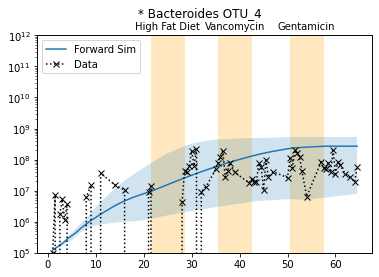

In [31]:
# Plot the forward sims, 25th-75th percentile
taxas = subj.taxas

low = np.percentile(M, q=25, axis=0)
high = np.percentile(M, q=75, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxas[oidx], taxas))
plt.show()

# Keystoneness
Calculate the keystoneness by using the `MDSINE2_Paper/keystoneness.py` script of the chain `uc100`.

Each line out table indicates which OTUs to leave out for that iteration of forward simulating to the steady state. Note that these are 0-based indecies for the OTUs.

In [53]:
# Make the leave out table - leave out each Cluster
os.makedirs('output/keystoneness', exist_ok=True)

mcmc = md2.BaseMCMC.load('output/mdsine2/uc100/mcmc.pkl')
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
print(clustering)

txt = '\n'.join([','.join([str(oidx) for oidx in cluster.members]) for cluster in clustering])
f = open('output/keystoneness/leave_out_table.csv', 'w')
f.write(txt)
f.close()
print(txt)

!python ../keystoneness.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --sep , \
    --simulation-dt 0.01 \
    --output-basepath output/keystoneness/ \
    --n-days 60

INFO:util.171: Number of clusters: 4
INFO:util.177: Clusters assigned: [0 1 0 0 1 3 3 0 1 0 2 0 3 3 0]


Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2110282281704
	members: ['OTU_17', 'OTU_16', 'OTU_6', 'OTU_7']
	size: 4
Cluster 2110268074472
	members: ['OTU_1', 'OTU_3', 'OTU_4', 'OTU_8', 'OTU_10', 'OTU_13', 'OTU_18']
	size: 7
Cluster 2110281509688
	members: ['OTU_9', 'OTU_2', 'OTU_5']
	size: 3
Cluster 2110238545064
	members: ['OTU_12']
	size: 1
13,12,5,6
0,2,3,7,9,11,14
8,1,4
10
(5, 15)
['OTU_1', 'OTU_2', 'OTU_3', 'OTU_4', 'OTU_5', 'OTU_6', 'OTU_7', 'OTU_8', 'OTU_9', 'OTU_10', 'OTU_12', 'OTU_13', 'OTU_16', 'OTU_17', 'OTU_18']
['base', '13,12,5,6', '0,2,3,7,9,11,14', '8,1,4', '10']


INFO:keystoneness.186: "all" provided as index. Iterating over each index
INFO:keystoneness.204: Forward simulating
INFO:keystoneness.209: Input is an MDSINE2.BaseMCMC object
INFO:keystoneness.241: not indexing out anything
INFO:keystoneness.80: 5/50 - 0.38301753997802734
INFO:keystoneness.80: 10/50 - 0.40132761001586914
INFO:keystoneness.80: 15/50 - 0.38188624382019043
INFO:keystoneness.80: 20/50 - 0.3924999237060547
INFO:keystoneness.80: 25/50 - 0.37303781509399414
INFO:keystoneness.80: 30/50 - 0.36600208282470703
INFO:keystoneness.80: 35/50 - 0.38300180435180664
INFO:keystoneness.80: 40/50 - 0.3811228275299072
INFO:keystoneness.80: 45/50 - 0.4115743637084961
INFO:keystoneness.232: indexing out [13, 12, 5, 6]
INFO:keystoneness.80: 5/50 - 0.4426558017730713
INFO:keystoneness.80: 10/50 - 0.41909098625183105
INFO:keystoneness.80: 15/50 - 0.39003610610961914
INFO:keystoneness.80: 20/50 - 0.39112353324890137
INFO:keystoneness.80: 25/50 - 0.3811218738555908
INFO:keystoneness.80: 30/50 - 0.

In [54]:
# Display the steady state table
df_steady_state = pd.read_csv('output/keystoneness/uc-toy-dataset/steady-state-table.tsv',
                sep='\t', index_col=0)
df_steady_state.head()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_12,OTU_13,OTU_16,OTU_17,OTU_18
base,3.788368e+10,1.485859e+10,6.475923e+10,6.221628e+08,5.051382e+09,1.419803e+10,6.965330e+09,1.095325e+10,3.946041e+06,2.503966e+07,3.395995e+09,7.876976e+07,4.870130e+09,3.179094e+09,2.375927e+09
"13,12,5,6",2.232936e+10,1.485859e+10,4.283392e+10,2.781816e+06,5.051382e+09,NaN,NaN,4.752345e+09,3.946041e+06,2.775518e+06,3.439159e+09,3.374055e+07,NaN,NaN,1.038042e+09
"0,2,3,7,9,11,14",NaN,1.485859e+10,NaN,NaN,5.051382e+09,6.423647e+10,1.971622e+10,NaN,3.946041e+06,NaN,3.395995e+09,NaN,7.068299e+09,4.483460e+09,NaN
"8,1,4",4.911176e+10,NaN,8.122889e+10,1.178077e+09,NaN,2.531560e+10,1.250896e+10,1.468027e+10,NaN,3.965867e+07,3.391573e+09,1.158017e+08,6.229388e+09,3.965058e+09,3.339014e+09
10,4.743585e+10,1.490856e+10,7.755019e+10,9.345719e+08,5.051481e+09,1.913252e+10,1.082105e+10,1.415784e+10,4.088132e+06,3.643543e+07,NaN,1.021334e+08,5.729323e+09,3.759481e+09,3.095329e+09


In [55]:
# Display the keystoneness table
df_keystoneness = pd.read_csv('output/keystoneness/uc-toy-dataset/keystoneness.tsv',
                sep='\t', index_col=0)
df_keystoneness.head()

,l2 distance
"13,12,5,6",2.837659e+10
"0,2,3,7,9,11,14",5.379519e+10
"8,1,4",2.599602e+10
10,1.899748e+10


# Perturbation analysis